# Test validity partial step 4, with only 1 term varying : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (C_{approx} + B^T N^{-1} B)^{-1}  N_c^{1/2} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import emcee
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import numpyro
from functools import partial
import micmac as micmac
# from mcmc_tools import *

from jax import config
config.update("jax_enable_x64", True)

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
# from get_freq_maps_SO_64 import *
from get_freq_maps_LiteBIRD_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(15, 2, 49152)
(15, 2, 49152)


In [3]:
instrument

frequency  depth_p  depth_i  fwhm  f_sky    status  \
0        40.0    37.42    26.46  70.5    1.0  forecast   
1        50.0    33.46    23.66  58.5    1.0  forecast   
2        60.0    21.31    15.07  51.1    1.0  forecast   
3        68.0    16.87    11.93  47.1    1.0  forecast   
4        78.0    12.07     8.53  43.8    1.0  forecast   
5        89.0    11.30     7.99  41.5    1.0  forecast   
6       100.0     6.56     4.64  37.8    1.0  forecast   
7       119.0     4.58     3.24  33.6    1.0  forecast   
8       140.0     4.79     3.39  30.8    1.0  forecast   
9       166.0     5.57     3.94  28.9    1.0  forecast   
10      195.0     5.85     4.14  28.6    1.0  forecast   
11      235.0    10.79     7.63  24.7    1.0  forecast   
12      280.0    13.80     9.76  22.5    1.0  forecast   
13      337.0    21.95    15.52  20.9    1.0  forecast   
14      402.0    47.45    33.55  17.9    1.0  forecast   

                     reference       type  \
0   arXiv:2202.02773, Table 13  satellite   
1   arXiv:2202.02773, Table 13  satellite   
2   arXiv:2202.02773, Table 13  satellite   
3   arXiv:2202.02773, Table 13  satellite   
4   arXiv:2202.02773, Table 13  satellite   
5   arXiv:2202.02773, Table 13  satellite   
6   arXiv:2202.02773, Table 13  satellite   
7   arXiv:2202.02773, Table 13  satellite   
8   arXiv:2202.02773, Table 13  satellite   
9   arXiv:2202.02773, Table 13  satellite   
10  arXiv:2202.02773, Table 13  satellite   
11  arXiv:2202.02773, Table 13  satellite   
12  arXiv:2202.02773, Table 13  satellite   
13  arXiv:2202.02773, Table 13  satellite   
14  arXiv:2202.02773, Table 13  satellite   

                                                 note experiment  
0   Different instruments at the same freq were co...   LiteBIRD  
1   Different instruments at the same freq were co...   LiteBIRD  
2   Different instruments at the same freq were co...   LiteBIRD  
3   Different instruments at the same freq were co...   LiteBIRD  
4   Different instruments at the same freq were co...   LiteBIRD  
5   Different instruments at the same freq were co...   LiteBIRD  
6   Different instruments at the same freq were co...   LiteBIRD  
7   Different instruments at the same freq were co...   LiteBIRD  
8   Different instruments at the same freq were co...   LiteBIRD  
9   Different instruments at the same freq were co...   LiteBIRD  
10  Different instruments at the same freq were co...   LiteBIRD  
11  Different instruments at the same freq were co...   LiteBIRD  
12  Different instruments at the same freq were co...   LiteBIRD  
13  Different instruments at the same freq were co...   LiteBIRD  
14  Different instruments at the same freq were co...   LiteBIRD

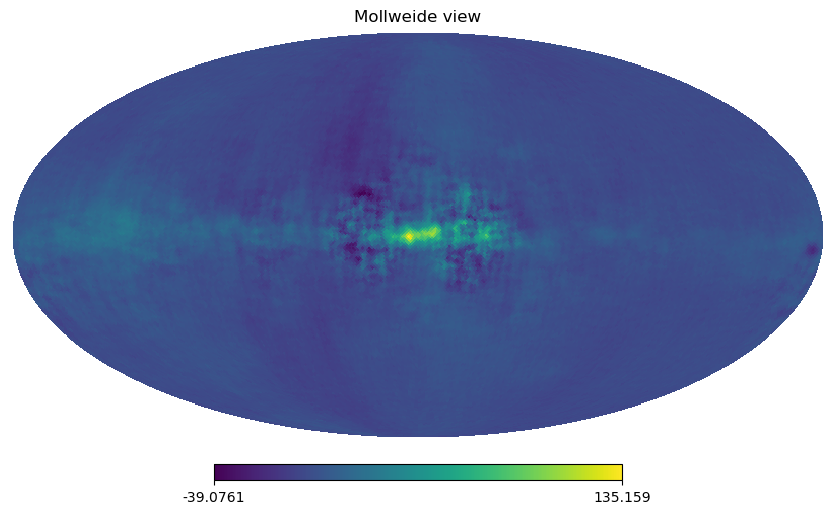

In [5]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [6]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [4]:
path_Fisher =  '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_sampling_step_4/fisher_litebird_d0s0_lmin2_lmax128_masked_Alens1.0_r0.0_B_noiselens.txt'
Fisher_matrix = np.loadtxt(path_Fisher)

Fisher_matrix_diag = np.zeros(Fisher_matrix.shape[0]-1)
Fisher_matrix_diag[:number_frequencies-2] = np.diag(Fisher_matrix)[number_frequencies-2:-1]
Fisher_matrix_diag[number_frequencies-2:] = np.diag(Fisher_matrix)[:number_frequencies-2]

In [7]:
r_chosen = 0
all_spectra = generate_power_spectra_CAMB(nside*2, r=r_chosen, typeless_bool=True)
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ells_input = np.zeros((6,lmax+1))
c_ells_input[:4,...] = camb_cls.T
c_ell_approx = np.zeros((6,lmax+1))
c_ell_approx[1] = camb_cls.T[1]
c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [8]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

# CMB covariance preparation
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[-1,0])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[-1,0])
# mixing_matrix_obj.update_params(mixing_matrix_obj.params/100)
mixing_matrix_sampled = mixing_matrix_obj.get_B()


# Noise initialization
depth_p = instrument['depth_p']
freq_inverse_noise = micmac.get_noise_covar(depth_p, nside)
cp_cp_noise = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [9]:
init_params.shape

(13, 2)

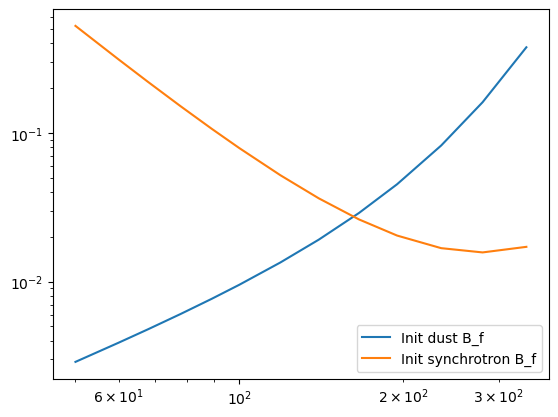

In [10]:
frequency_Bf = instrument['frequency'][1:-1]

plt.plot(frequency_Bf, init_params[:,0], label='Init dust B_f')
plt.plot(frequency_Bf, init_params[:,1], label='Init synchrotron B_f')
plt.legend()
plt.loglog()
plt.show()

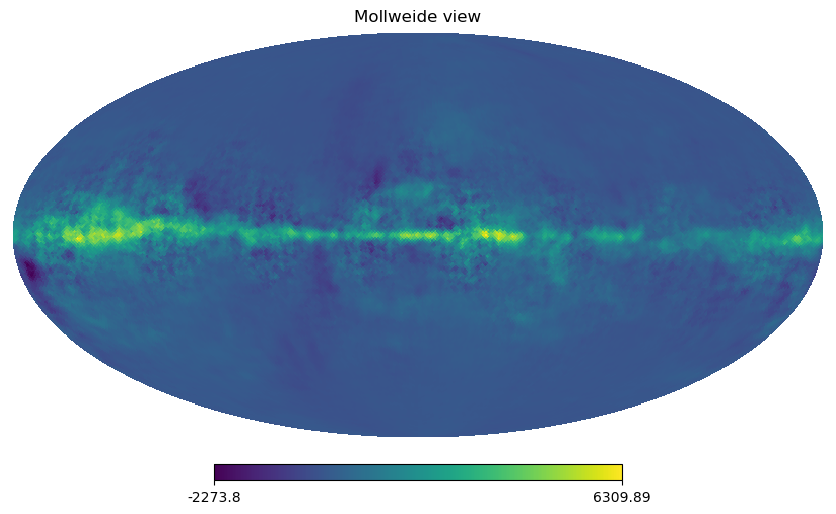

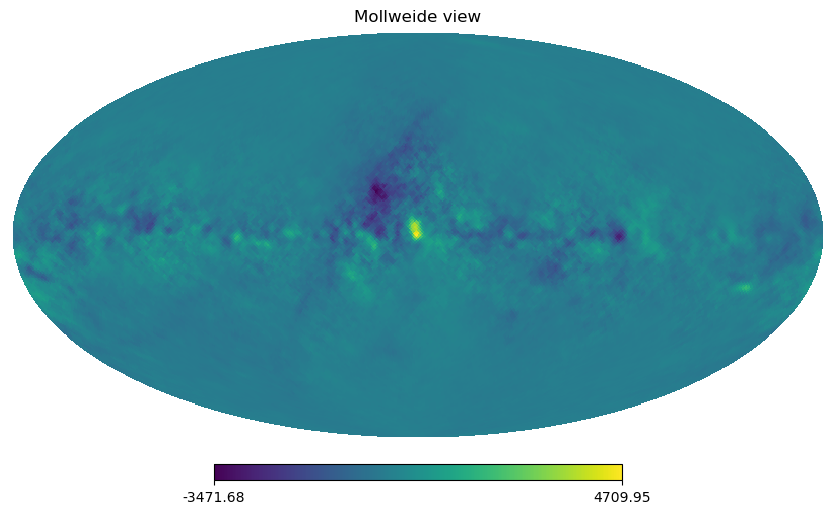

In [11]:
maps_cpnt = np.einsum('cf,fsp->csp', mixing_matrix_sampled.T, freq_maps)

hp.mollview(maps_cpnt[0][0])
hp.mollview(maps_cpnt[0][1])

In [12]:
# hp.mollview(maps_cpnt[1][0])
# hp.mollview(maps_cpnt[1][1])
# hp.mollview(maps_cpnt[2][0])
# hp.mollview(maps_cpnt[2][1])

## Sampling $\eta$ : $P(\eta | ...) \propto \eta^t (S_{approx} + E^t (B^t N^{-1} B)^{-1} E) \eta$

In [13]:
%%time
eta_maps = np.zeros((nstokes, npix))
map_random_x = []
map_random_y = []
eta_maps = micmac.get_sampling_eta(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
eta_prime_maps = get_sampling_eta_prime(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)


Recalculating x !
Recalculating y !
CG-Python eta sampling finished in  0 iterations !!
Recalculating x !
Recalculating y !
CPU times: user 515 ms, sys: 116 ms, total: 631 ms
Wall time: 170 ms


## Constrained map realization $s_c$ : $P(s_c | ...) \propto (s_c - s_{c,ML})^t (S_c + E^t (B^t N^{-1} B)^{-1} E)^{-1} (s_c - s_{c,ML})$

In [14]:
s_cML = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0,...]

### Fluctuation part

In [15]:
%%time
initial_guess = np.zeros((nstokes,npix))
map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
fluctuation_maps = micmac.get_fluctuating_term_maps(param_dict, red_cov_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 Fluct finished in  112 iterations !!
CPU times: user 12.6 s, sys: 1.62 s, total: 14.2 s
Wall time: 3.51 s


### Wiener filter part

In [16]:
%%time
initial_guess = np.zeros((nstokes,npix))
wiener_filter_term = micmac.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix, cp_cp_noise, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 WF finished in  125 iterations !!
CPU times: user 14 s, sys: 1.98 s, total: 16 s
Wall time: 4.57 s


In [17]:
s_c_map = wiener_filter_term + fluctuation_maps

## Sampling $C$ through inverse Wishart sampling : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$

In [18]:
%%time
c_ells_Wishart = micmac.get_cell_from_map(s_c_map, lmax=lmax, n_iter=n_iter)


CPU times: user 94.8 ms, sys: 11.2 ms, total: 106 ms
Wall time: 35.6 ms


In [19]:
%%time
red_c_ells_inv_Wishart_sample = np.zeros((lmax+1, nstokes, nstokes))
c_ells_inv_Wishart_sample = np.zeros((number_correlations, lmax+1))

red_c_ells_inv_Wishart_sample = micmac.get_inverse_wishart_sampling_from_c_ells(np.copy(c_ells_Wishart), l_min=lmin)#[lmin:]
c_ells_inv_Wishart_sample = micmac.get_c_ells_from_red_covariance_matrix(red_c_ells_inv_Wishart_sample)

CPU times: user 24 ms, sys: 7.69 ms, total: 31.7 ms
Wall time: 16 ms


## Few statistics before sampling $\bold{B_f}$ 

## Sampling $\bold{B_f}$ : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (C_{approx} + E^t (B^T N^{-1} B)^{-1} E)^{-1} N_c^{1/2} \eta$

In [20]:
s_c_map_extended = np.zeros((number_components, nstokes, npix))
s_c_map_extended[0,...] = s_c_map

full_current_mixing_matrix = mixing_matrix_obj.get_B()

full_data_without_CMB = freq_maps - np.einsum('fc,csp->fsp',full_current_mixing_matrix, s_c_map_extended)

In [21]:
complete_mixing_matrix_fg = mixing_matrix_obj.get_B_fgs()
cp_freq_inv_noise_fg = micmac.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg)
cp_cp_noise_fg = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg)
print(cp_freq_inv_noise_fg, cp_freq_inv_noise_fg.shape, full_data_without_CMB.shape)

map_fgs = np.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
print('d-Bcsc -- mean', np.mean(full_data_without_CMB), 'max', np.max(full_data_without_CMB), 'min', np.min(full_data_without_CMB))
print('B_fN^{-1} (d-Bcsc) - mean', np.mean(map_fgs), 'max', np.max(map_fgs), 'min', np.min(map_fgs))
print('B_fN^{-1} - mean', np.mean(cp_freq_inv_noise_fg), 'max', np.max(cp_freq_inv_noise_fg), 'min', np.min(cp_freq_inv_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean FG', np.mean(cp_cp_noise_fg), 'max', np.max(cp_cp_noise_fg), 'min', np.min(cp_cp_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean', np.log(np.linalg.det(cp_cp_noise)))

[[0.         0.00778423 0.02581475 0.05075681 0.12550375 0.18118873
  0.66801792 1.93593892 2.52022378 2.8181711  3.98374514 2.13339904
  2.54865311 2.35908526 1.34197369]
 [2.15778848 1.41393232 2.07454769 2.33367924 3.13362704 2.51955412
  5.54829428 7.47503514 4.77783258 2.54838312 1.80020096 0.43534911
  0.24915785 0.10737359 0.        ]] (2, 15) (15, 2, 49152)
d-Bcsc -- mean 9.055347185355314 max 3459.81437788204 min -1966.313282127043
B_fN^{-1} (d-Bcsc) - mean 144.84416543527584 max 10996.419804559704 min -6209.795338337066
B_fN^{-1} - mean 1.9091670580479396 max 7.475035143860341 min 0.0
(B_f^t N^{-1} B_f)^{-1} - mean FG 0.10787996205566348 max 0.322343873052212 min -0.03145960092805792
(B_f^t N^{-1} B_f)^{-1} - mean -8.699422931664065


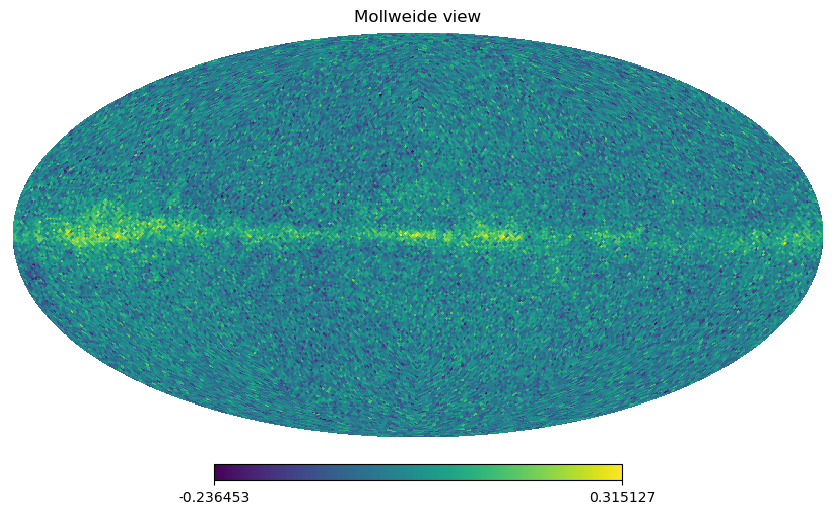

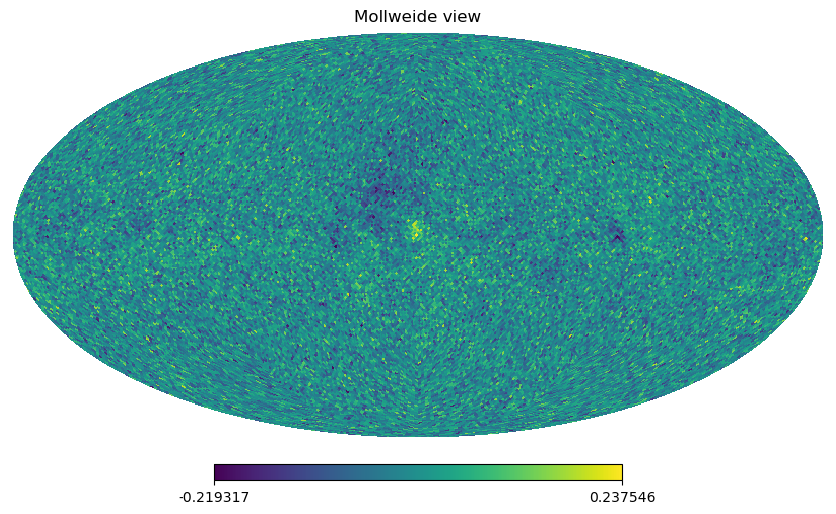

In [22]:
first_residual = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]
hp.mollview(first_residual[0])
hp.mollview(first_residual[1])

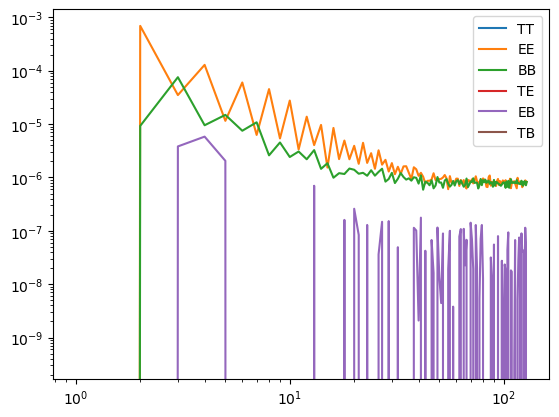

In [23]:
c_ell_first_residual = hp.anafast(np.vstack([np.zeros_like(first_residual[0]),first_residual]), lmax=lmax, iter=n_iter)
ell_arange = np.arange(c_ell_first_residual.shape[1])
plt.plot(ell_arange, c_ell_first_residual.T)
# plt.plot(ell_arange, np.abs(c_ell_first_residual).T)
plt.loglog()
plt.legend(['TT', 'EE', 'BB', 'TE', 'EB', 'TB'])
plt.show()

In [24]:
regularization_constant = -10**(12)

In [25]:
# @partial(jax.jit, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints', 'regularization_constant'])
# def get_conditional_proba_spectral_likelihood_JAX(complete_mixing_matrix, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False, regularization_constant=-10**12):
#     """ Get conditional probability of spectral likelihood by sampling it using emcee

#         The associated conditional probability is given by : 
#         - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
#     """

#     # Building the spectral_likelihood : - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
#     complete_mixing_matrix_fg = complete_mixing_matrix[:,1:]

#     cp_cp_noise_fg = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg, jax_use=True)
#     cp_freq_inv_noise_fg = micmac.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg, jax_use=True)

#     full_data_without_CMB_with_noise = jnp.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
#     first_term_complete = jnp.einsum('psc,cm,msp', full_data_without_CMB_with_noise.T, cp_cp_noise_fg, full_data_without_CMB_with_noise)

#     return -(-first_term_complete + 0)/2. + regularization_constant

# def new_get_conditional_proba_spectral_likelihood_JAX(params_mixing_matrix, pos_special_freqs=[-1,0], **model_kwargs):
#     new_mixing_matrix = micmac.create_mixing_matrix_jax(params_mixing_matrix, param_dict['number_components'], param_dict['number_frequencies'], pos_special_freqs=pos_special_freqs)
#     return get_conditional_proba_spectral_likelihood_JAX(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), jnp.array(model_kwargs['eta_prime_maps']), freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'], regularization_constant=model_kwargs['regularization_constant'])


@partial(jax.jit, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints', 'regularization_constant'])
def get_conditional_proba_spectral_likelihood_JAX(complete_mixing_matrix, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False, regularization_constant=-10**12):
    """ Get conditional probability of spectral likelihood by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    """

    # Building the spectral_likelihood : - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    complete_mixing_matrix_fg = complete_mixing_matrix[:,1:]

    cp_cp_noise_fg = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg, jax_use=True)
    cp_freq_inv_noise_fg = micmac.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg, jax_use=True)

    full_data_without_CMB_with_noise = jnp.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
    first_term_complete = jnp.einsum('psc,cm,msp', full_data_without_CMB_with_noise.T, cp_cp_noise_fg, full_data_without_CMB_with_noise)

    return -(-first_term_complete + 0)/2. + regularization_constant

def new_get_conditional_proba_spectral_likelihood_JAX(value_param_mixing_matrix, freq_param, cpt_param, pos_special_freqs=[-1,0], **model_kwargs):
    # freq_param, cpt_param #= components_single_param
    params_mixing_matrix = jnp.copy(init_params)
    print("Test", freq_param, cpt_param)
    params_mixing_matrix = params_mixing_matrix.at[freq_param,cpt_param].set(value_param_mixing_matrix)
    new_mixing_matrix = micmac.create_mixing_matrix_jax(params_mixing_matrix, param_dict['number_components'], param_dict['number_frequencies'], pos_special_freqs=pos_special_freqs)
    return get_conditional_proba_spectral_likelihood_JAX(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), jnp.array(model_kwargs['eta_prime_maps']), freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'], regularization_constant=model_kwargs['regularization_constant'])


In [26]:

@partial(jax.jit, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints', 'regularization_constant'])
def get_conditional_proba_full_likelihood_JAX(complete_mixing_matrix, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False, regularization_constant=-10**12):
    """ Get conditional probability of spectral likelihood by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    """

    # Building the first term of spectral_likelihood : - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    complete_mixing_matrix_fg = complete_mixing_matrix[:,1:]

    cp_cp_noise_fg = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg, jax_use=True)
    cp_freq_inv_noise_fg = micmac.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg, jax_use=True)

    full_data_without_CMB_with_noise = jnp.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
    first_term_complete = jnp.einsum('psc,cm,msp', full_data_without_CMB_with_noise.T, cp_cp_noise_fg, full_data_without_CMB_with_noise)

    ## Left hand side term : N_c^{1/2] \eta = (E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} \eta
    # noise_weighted_eta = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise_sqrt, eta_maps)[0] # Selecting CMB component
    # eta_prime_maps_extended = jnp.array(np.zeros((param_dict['number_components'],param_dict['nstokes'],12*param_dict['nside']**2)))
    eta_prime_maps_extended = jnp.zeros((number_components,nstokes,12*nside**2))
    # eta_prime_maps_extended[0] = eta_prime_maps
    eta_prime_maps_extended = eta_prime_maps_extended.at[0].set(eta_prime_maps)
    noise_weighted_eta = jnp.einsum('kc,csp->ksp', cp_cp_noise, eta_prime_maps_extended)[0] # Selecting CMB component

    # Then getting (C_approx + E^t (B^t N^{-1} B)^{-1} E)^{-1} N_c^{1/2] \eta
    operator_harmonic = red_cov_approx_matrix
    operator_pixel = cp_cp_noise
    # print("Test 3 :", lmin, flush=True)
    inverse_term = get_inverse_operators_harm_pixel_JAX(number_components, nstokes, nside, noise_weighted_eta, operator_harmonic, operator_pixel, initial_guess=[], lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance, with_prints=with_prints)

    # And finally \eta^t N_c^{1/2] (C_approx + E^t (B^t N^{-1} B)^{-1} E)^{-1} N_c^{1/2] \eta
    # second_term_complete = np.einsum('fsk,fsk', noise_weighted_eta, inverse_term)
    second_term_complete = jnp.einsum('sk,sk', noise_weighted_eta, inverse_term)

    return -(-first_term_complete + second_term_complete)/2. + regularization_constant

def new_get_conditional_proba_full_likelihood_JAX(value_param_mixing_matrix, freq_param, cpt_param, pos_special_freqs=[-1,0], **model_kwargs):
    # freq_param, cpt_param #= components_single_param
    params_mixing_matrix = jnp.copy(init_params)
    print("Test", freq_param, cpt_param)
    params_mixing_matrix = params_mixing_matrix.at[freq_param,cpt_param].set(value_param_mixing_matrix)
    new_mixing_matrix = micmac.create_mixing_matrix_jax(params_mixing_matrix, param_dict['number_components'], param_dict['number_frequencies'], pos_special_freqs=pos_special_freqs)
    return get_conditional_proba_full_likelihood_JAX(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), jnp.array(model_kwargs['eta_prime_maps']), freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=model_kwargs['lmin'], n_iter=model_kwargs['n_iter'], limit_iter_cg=model_kwargs['limit_iter_cg'], tolerance=model_kwargs['tolerance'], with_prints=model_kwargs['with_prints'], regularization_constant=model_kwargs['regularization_constant'])


In [27]:
%%time

# Calculation value log_proba with current value of B_f

# log_proba = micmac.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)


freq_coord = 0
cpt_coord = 0
# components_single_param_coord = [freq_coord,cpt_coord]
# log_proba = new_get_conditional_proba_spectral_likelihood_JAX(mixing_matrix_obj.params, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant)
log_proba = new_get_conditional_proba_spectral_likelihood_JAX(mixing_matrix_obj.params[freq_coord,cpt_coord], freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant)
print("Log_proba :", log_proba)
print("<-> Proba :", jnp.exp(log_proba))

Test 0 0
Log_proba : -982834126995.3333
<-> Proba : 0.0
CPU times: user 1.04 s, sys: 62.6 ms, total: 1.11 s
Wall time: 1.25 s


In [28]:
jitted_new_get_conditional_proba_spectral_likelihood_JAX = jax.jit(new_get_conditional_proba_spectral_likelihood_JAX, static_argnames=['with_prints'])
jitted_new_get_conditional_proba_full_likelihood_JAX = jax.jit(new_get_conditional_proba_full_likelihood_JAX, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints', 'regularization_constant'])

In [29]:
%%time

# Calculation value log_proba with current value of B_f
with_prints_ = True
log_proba = jitted_new_get_conditional_proba_spectral_likelihood_JAX(mixing_matrix_obj.params[freq_coord,cpt_coord], freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints_, regularization_constant=regularization_constant)
print("Log_proba :", log_proba)
print("<-> Proba :", jnp.exp(log_proba))

Test Traced<ShapedArray(int64[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(int64[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
Log_proba : -982834126995.3333
<-> Proba : 0.0
CPU times: user 202 ms, sys: 32.8 ms, total: 235 ms
Wall time: 231 ms


In [30]:
%%time

# Calculation value log_proba with current value of B_f
with_prints_ = True
log_proba = jitted_new_get_conditional_proba_full_likelihood_JAX(mixing_matrix_obj.params[freq_coord,cpt_coord], freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints_, regularization_constant=regularization_constant)
print("Log_proba :", log_proba)
print("<-> Proba :", jnp.exp(log_proba))

Test Traced<ShapedArray(int64[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(int64[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
CG-Python-0 WF finished in  None iterations !!
Log_proba : -982834128810.9398
<-> Proba : 0.0
CPU times: user 3.21 s, sys: 417 ms, total: 3.63 s
Wall time: 2.23 s


In [31]:
initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel(order='F')
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)
dimensions_mixing_matrix = 1

freq_coord = -1
cpt_coord = 0
components_single_param_coord = [freq_coord,cpt_coord]

initial_guess_fg_mixing_matrix = mixing_matrix_obj.params[freq_coord, cpt_coord]
# full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.95,high=initial_guess_fg_mixing_matrix*1.05, size=(n_walkers,dimensions_mixing_matrix))
full_initial_guess = np.copy(initial_guess_fg_mixing_matrix)
# full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.05,high=initial_guess_fg_mixing_matrix*10.05, size=(n_walkers,dimensions_mixing_matrix))

# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)
print(mixing_matrix_obj.params, full_initial_guess)

[[0.00288437 0.52391889]
 [0.00387988 0.3117984 ]
 [0.00478088 0.21981377]
 [0.00605139 0.15109337]
 [0.00765723 0.10647904]
 [0.00951436 0.07902249]
 [0.01344021 0.05189527]
 [0.01913787 0.03628152]
 [0.02893752 0.02616729]
 [0.04512184 0.02038996]
 [0.08220506 0.01677506]
 [0.16063955 0.01570422]
 [0.37618047 0.01712183]] 0.37618047497655904


## Fisher

In [54]:
minimum_std_Fisher = scipy.linalg.sqrtm(np.linalg.inv(Fisher_matrix))
np.diag(minimum_std_Fisher)

minimum_std_Fisher_diag = np.zeros(minimum_std_Fisher.shape[0]-1)
minimum_std_Fisher_diag[:number_frequencies-2] = np.diag(minimum_std_Fisher)[number_frequencies-2:-1]
minimum_std_Fisher_diag[number_frequencies-2:] = np.diag(minimum_std_Fisher)[:number_frequencies-2]

# Griding

In [55]:
griding_logspace = np.logspace(-10,10)
# griding_logspace = np.linspace(-10,10)

# log_proba_griding = []
log_proba_samples_list = [jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace]

log_full_proba_samples_list = [jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace]

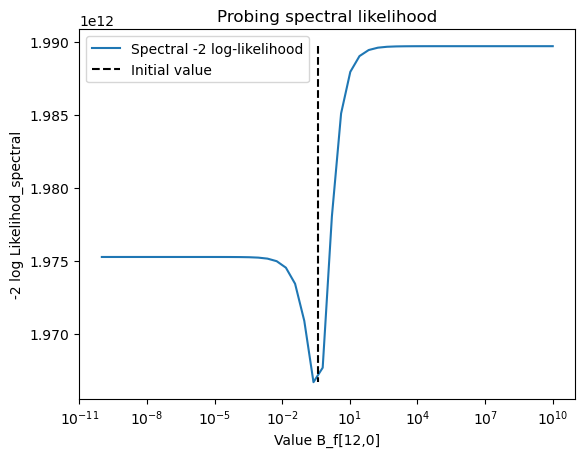

In [56]:
log_proba_griding = np.array(log_proba_samples_list)

initial_value = init_params[freq_coord, cpt_coord]


plt.plot(griding_logspace, -2*log_proba_griding, label='Spectral -2 log-likelihood')
plt.plot([initial_value,initial_value], [-2*log_proba_griding.min(),-2*log_proba_griding.max()], 'k--', label='Initial value')
plt.xscale('log')
plt.xlabel('Value B_f[{},{}]'.format(freq_coord, cpt_coord))
plt.ylabel('-2 log Likelihod_spectral')
plt.title('Probing spectral likelihood')
plt.legend()
plt.show()

In [57]:
# griding_logspace = np.logspace(-10,10)
griding_logspace = np.concatenate((np.flip(-np.logspace(-8,1,num=25)), np.logspace(-8,1,num=25)))

# log_proba_griding = []
# log_proba_samples_list = [jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace]
log_proba_samples_dust_list = np.empty((number_frequencies-2, griding_logspace.shape[0]))
log_proba_samples_synch_list = np.empty((number_frequencies-2, griding_logspace.shape[0]))
for freq_coord in range(number_frequencies-2):
    log_proba_samples_dust_list[freq_coord,...] = np.array([jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace])
    log_proba_samples_synch_list[freq_coord,...] = np.array([jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace])


log_proba_samples_dust_full_proba = np.empty((number_frequencies-2, griding_logspace.shape[0]))
log_proba_samples_synch_full_proba = np.empty((number_frequencies-2, griding_logspace.shape[0]))
for freq_coord in range(number_frequencies-2):
    print("Nb freq :", freq_coord, number_frequencies-2)
    log_proba_samples_dust_full_proba[freq_coord,...] = np.array([jitted_new_get_conditional_proba_full_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace])
    print("Nb freq n°2 :", freq_coord, number_frequencies-2)
    log_proba_samples_synch_full_proba[freq_coord,...] = np.array([jitted_new_get_conditional_proba_full_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace])

Nb freq : 0 13
Nb freq n°2 : 0 13
Nb freq : 1 13
Nb freq n°2 : 1 13
Nb freq : 2 13
Nb freq n°2 : 2 13
Nb freq : 3 13
Nb freq n°2 : 3 13
Nb freq : 4 13
Nb freq n°2 : 4 13
Nb freq : 5 13
Nb freq n°2 : 5 13
Nb freq : 6 13
Nb freq n°2 : 6 13
Nb freq : 7 13
Nb freq n°2 : 7 13
Nb freq : 8 13
Nb freq n°2 : 8 13
Nb freq : 9 13
Nb freq n°2 : 9 13
Nb freq : 10 13
Nb freq n°2 : 10 13
Nb freq : 11 13
Nb freq n°2 : 11 13
Nb freq : 12 13
Nb freq n°2 : 12 13


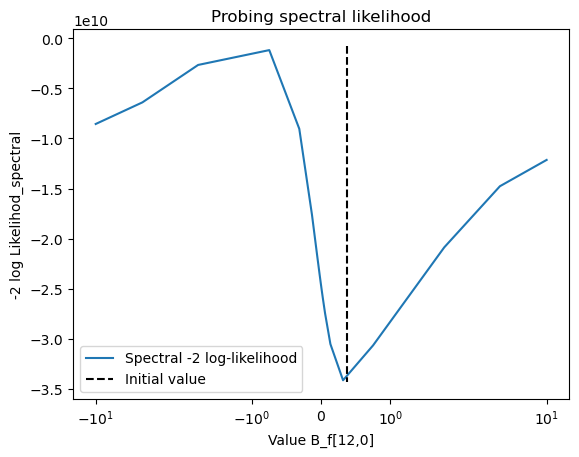

In [58]:
log_proba_griding_dust = np.array(log_proba_samples_dust_list)-regularization_constant

initial_value = init_params[freq_coord, cpt_coord]


plt.plot(griding_logspace, -2*log_proba_griding_dust[-1,:], label='Spectral -2 log-likelihood')
# for freq_coord in range(number_frequencies-2):
#     plt.plot(griding_logspace, -2*log_proba_griding.T, '--', alpha=.1)

plt.plot([initial_value,initial_value], [-2*log_proba_griding_dust.min(),-2*log_proba_griding_dust.max()], 'k--', label='Initial value')
plt.xscale('symlog')
plt.xlabel('Value B_f[{},{}]'.format(freq_coord, cpt_coord))
plt.ylabel('-2 log Likelihod_spectral')
plt.title('Probing spectral likelihood')
plt.legend()
plt.show()

In [59]:
log_proba_griding_dust.shape

(13, 50)

In [60]:
freq_coord = 0
min_value = (-2*log_proba_griding_dust[freq_coord,:]).max()
print(min_value, np.log10(-min_value))
-2*log_proba_griding_dust[freq_coord,:]

-926224169.9438477 8.966716109778455


array([-1.65258726e+09, -3.90845454e+09, -1.16700268e+10, -2.46870070e+10,
       -3.19909370e+10, -3.38745065e+10, -3.42450530e+10, -3.43145256e+10,
       -3.43278867e+10, -3.43306631e+10, -3.43313244e+10, -3.43315125e+10,
       -3.43315757e+10, -3.43315995e+10, -3.43316090e+10, -3.43316129e+10,
       -3.43316146e+10, -3.43316152e+10, -3.43316155e+10, -3.43316157e+10,
       -3.43316157e+10, -3.43316157e+10, -3.43316157e+10, -3.43316157e+10,
       -3.43316157e+10, -3.43316157e+10, -3.43316158e+10, -3.43316158e+10,
       -3.43316158e+10, -3.43316158e+10, -3.43316158e+10, -3.43316160e+10,
       -3.43316162e+10, -3.43316169e+10, -3.43316185e+10, -3.43316223e+10,
       -3.43316311e+10, -3.43316507e+10, -3.43316904e+10, -3.43317461e+10,
       -3.43316631e+10, -3.43302541e+10, -3.43200884e+10, -3.42575644e+10,
       -3.38953356e+10, -3.19377720e+10, -2.38794654e+10, -9.60900447e+09,
       -2.37849131e+09, -9.26224170e+08])

In [61]:
freq_coord = -1
minimum_std_Fisher_diag[freq_coord], init_params[freq_coord, 0]

(0.0010201808612410315, 0.37618047497655904)

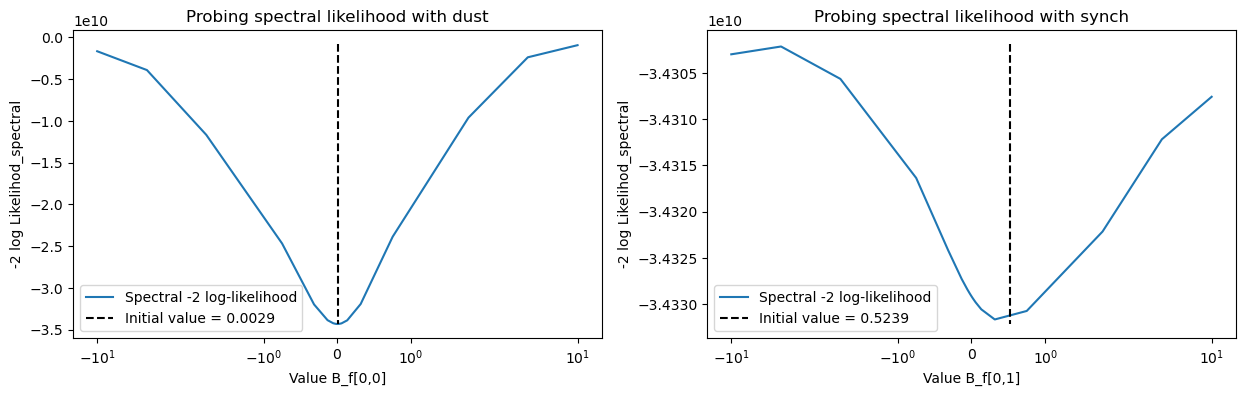

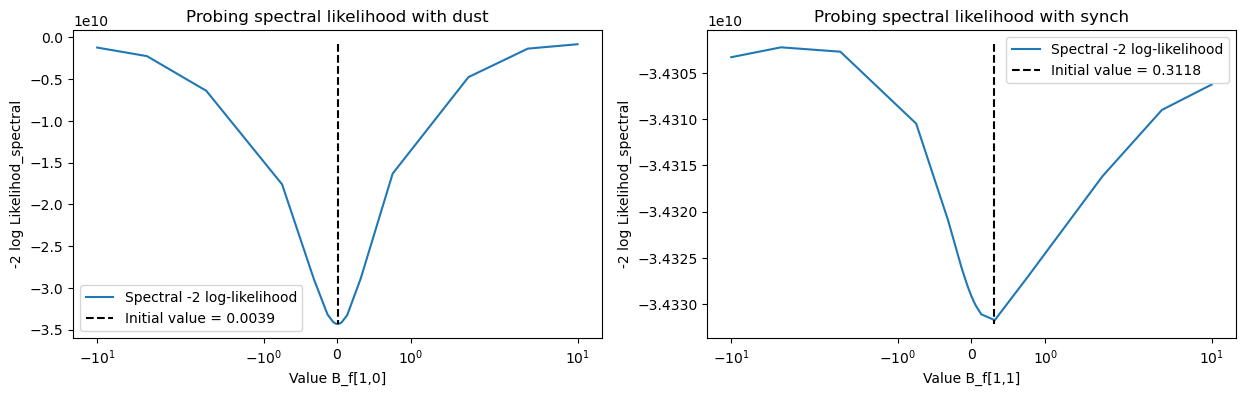

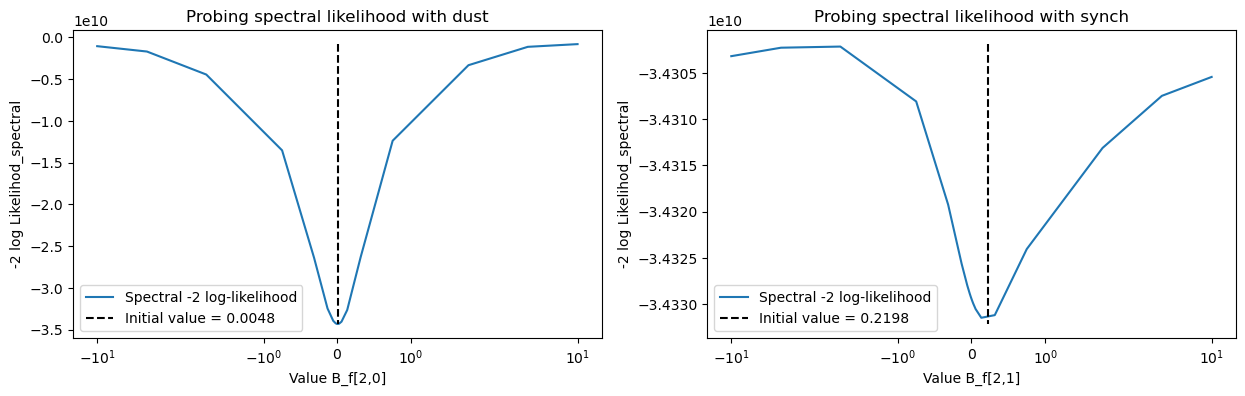

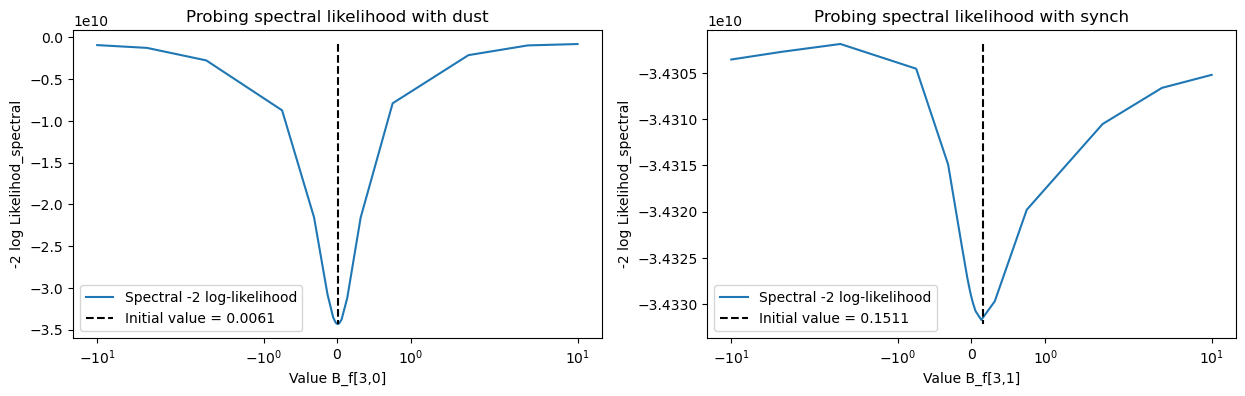

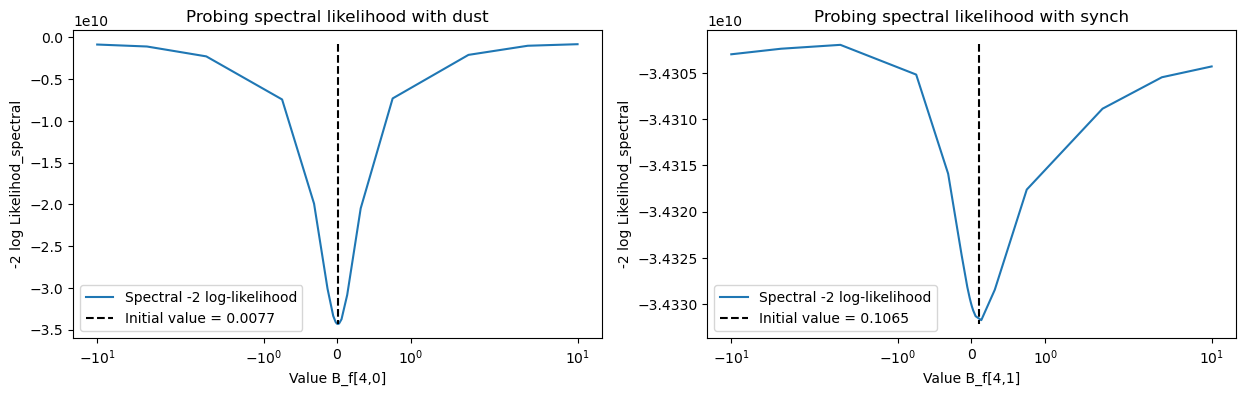

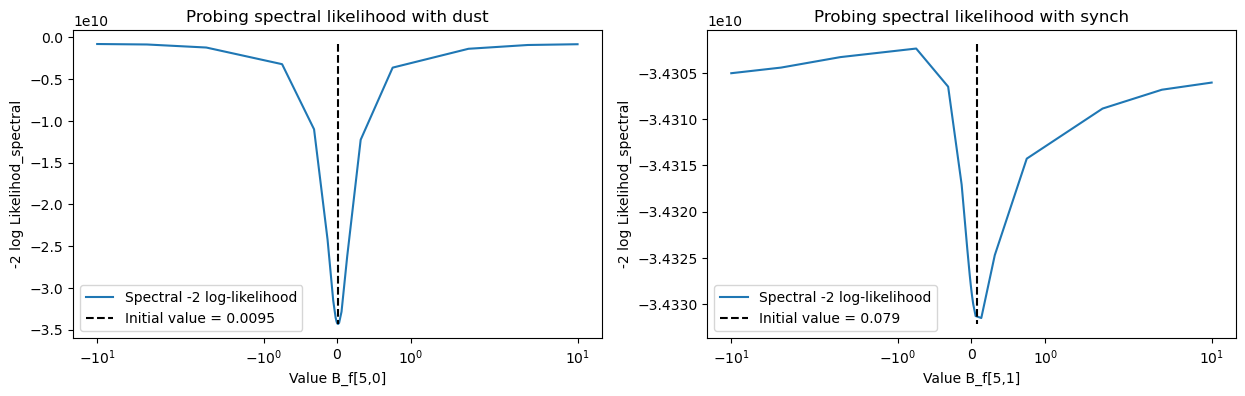

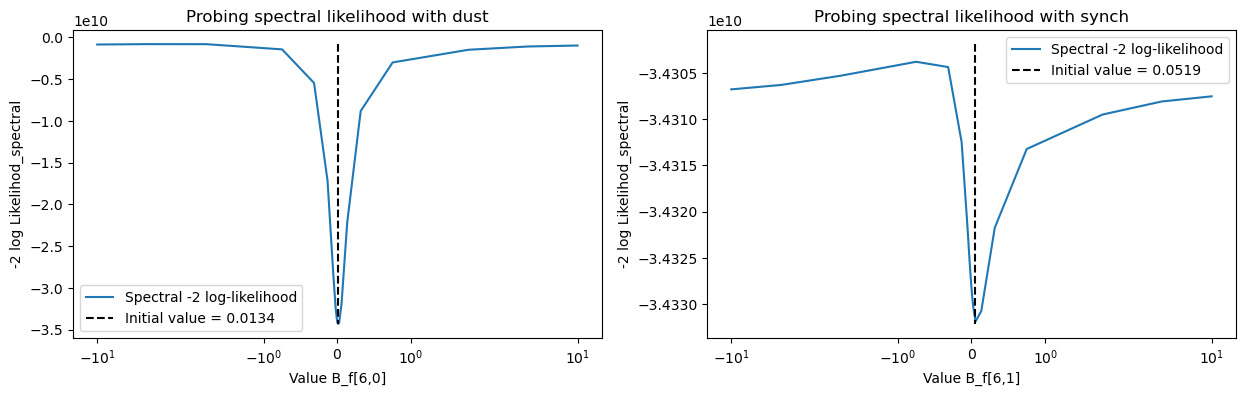

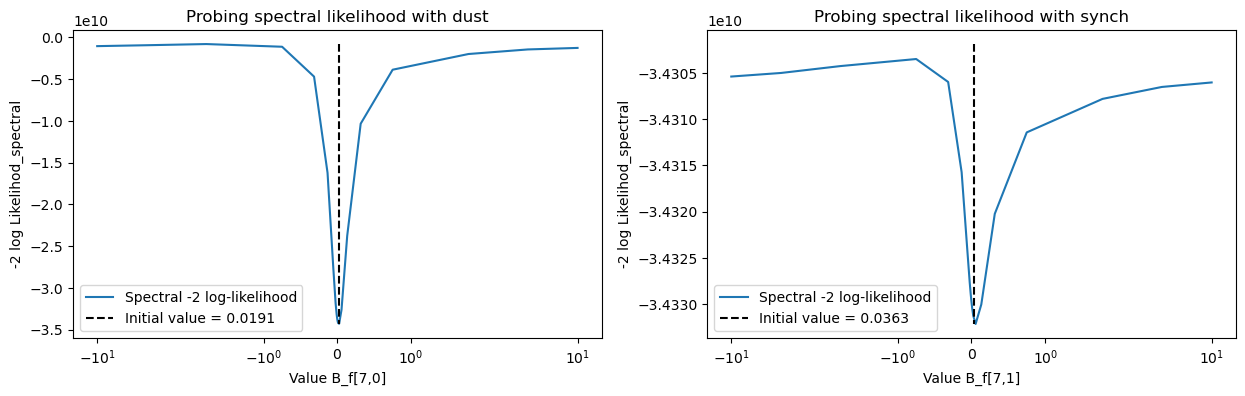

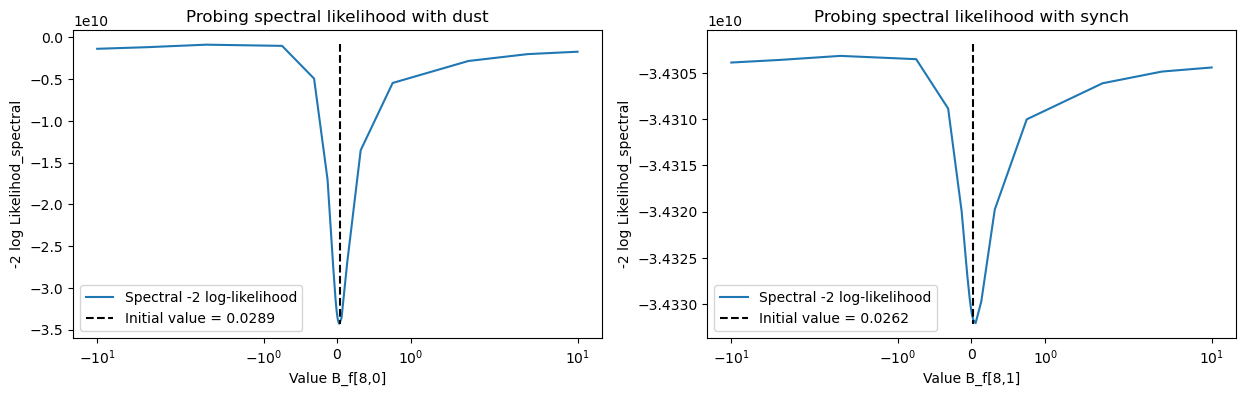

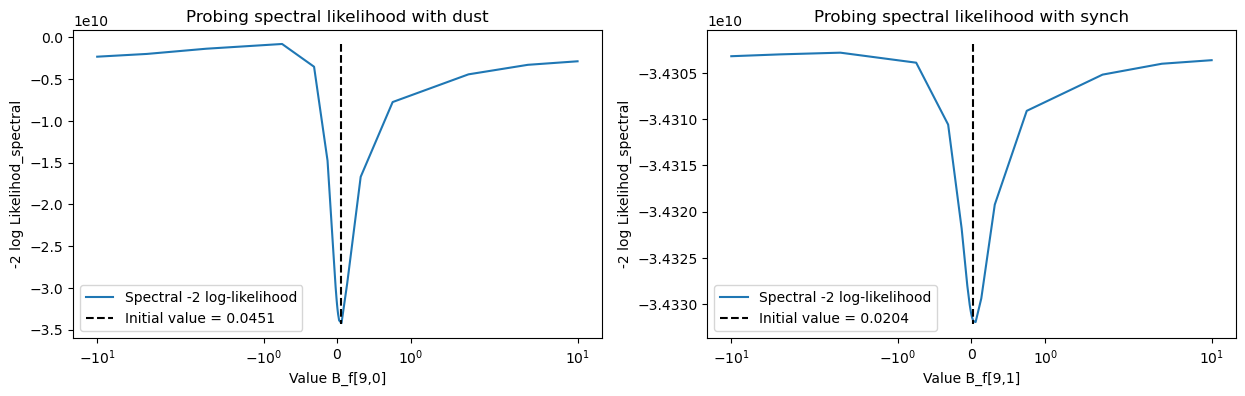

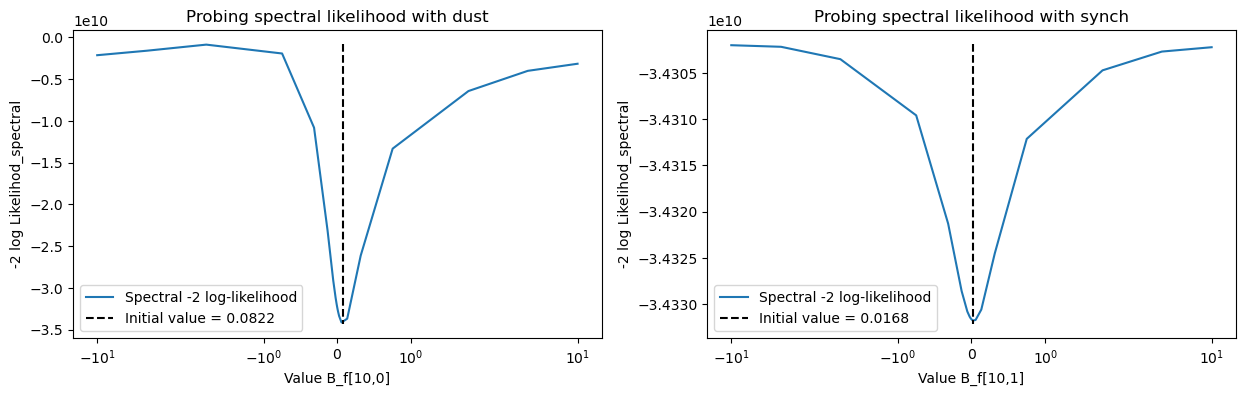

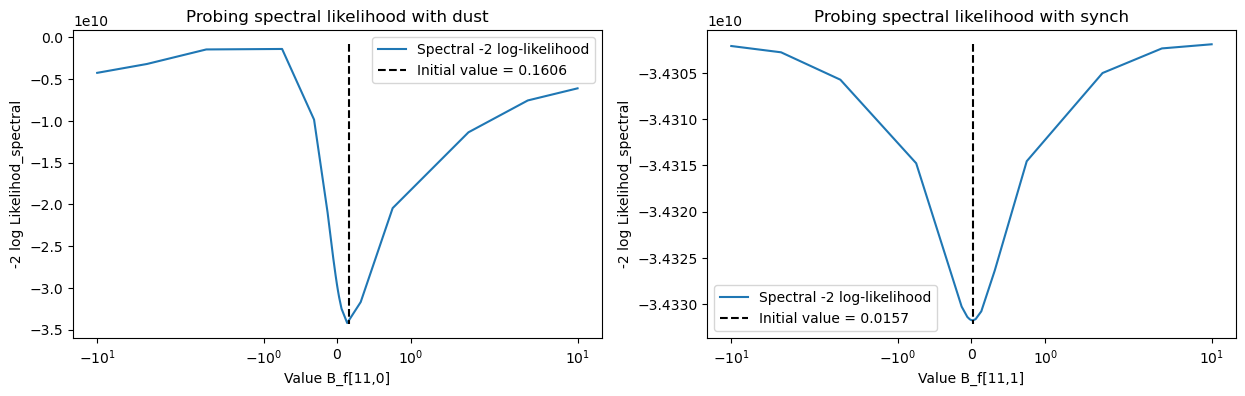

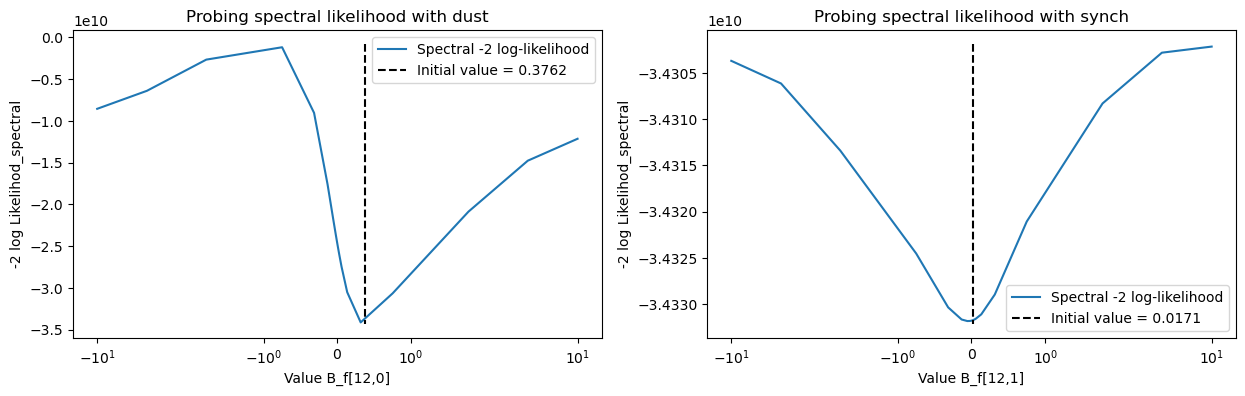

In [62]:
log_proba_griding_dust = np.array(log_proba_samples_dust_list)-regularization_constant
log_proba_griding_synch = np.array(log_proba_samples_synch_list)-regularization_constant

# percent_value = 200
# nb_Fisher = 5

# number_subplot = (number_frequencies-2)*100 + 20
n_decimals = 4
for freq_coord in range(number_frequencies-2):
    plt.figure(figsize=(15,4))
    initial_value = init_params[freq_coord, cpt_coord]
    initial_value_rounded = np.round(initial_value, decimals=n_decimals)
    # plt.subplot((number_frequencies-2,2,freq_coord*2))
    plt.subplot(121)
    # min_value = (-2*log_proba_griding_dust[freq_coord,:]).min()
    plt.plot(griding_logspace, -2*log_proba_griding_dust[freq_coord,:], label='Spectral -2 log-likelihood')
    # for freq_coord in range(number_frequencies-2):
    #     plt.plot(griding_logspace, -2*log_proba_griding.T, '--', alpha=.1)

    plt.plot([initial_value,initial_value], [-2*log_proba_griding_dust.min(),-2*log_proba_griding_dust.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # sigma_B_f = initial_value*percent_value/100.
    # sigma_B_f = nb_Fisher*np.diag(minimum_std_Fisher)[freq_coord]
    # half_value = -np.median(log_proba_griding_dust[freq_coord,:])/2
    # # plt.plot([initial_value-sigma_B_f,initial_value+sigma_B_f], [half_value,half_value], 'r', label=r"$\sigma (B_{f})$"+f"~{percent_value}%")
    # plt.plot([initial_value-sigma_B_f,initial_value+sigma_B_f], [half_value,half_value], 'r', label=f"{nb_Fisher}"+r"$\sigma_{Fisher}$")
    # plt.plot([initial_value,initial_value], [0,((-2*log_proba_griding_dust[freq_coord,:]).max()-min_value).max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    plt.xscale('symlog')
    plt.xlabel('Value B_f[{},{}]'.format(freq_coord, cpt_coord))
    plt.ylabel('-2 log Likelihod_spectral')
    plt.title('Probing spectral likelihood with dust')
    plt.legend()

    initial_value = init_params[freq_coord, cpt_coord+1]
    initial_value_rounded = np.round(initial_value, decimals=n_decimals)
    # plt.subplot((number_frequencies-2,2,freq_coord*2+1))
    plt.subplot(122)
    plt.plot(griding_logspace, -2*log_proba_griding_synch[freq_coord,:], label='Spectral -2 log-likelihood')
    # for freq_coord in range(number_frequencies-2):
    #     plt.plot(griding_logspace, -2*log_proba_griding.T, '--', alpha=.1)

    plt.plot([initial_value,initial_value], [-2*log_proba_griding_synch.min(),-2*log_proba_griding_synch.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    plt.xscale('symlog')
    plt.xlabel('Value B_f[{},{}]'.format(freq_coord, cpt_coord+1))
    plt.ylabel('-2 log Likelihod_spectral')
    plt.title('Probing spectral likelihood with synch')
    plt.legend()
    plt.show()


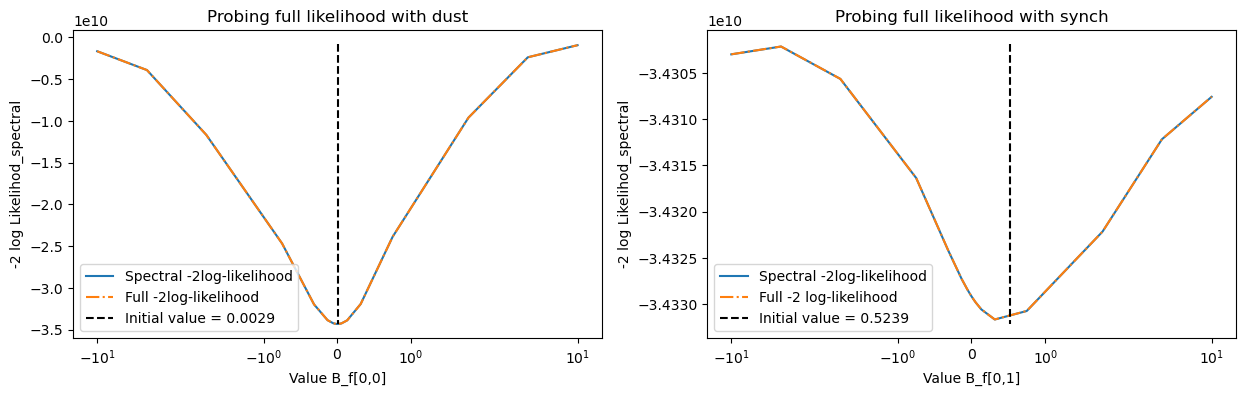

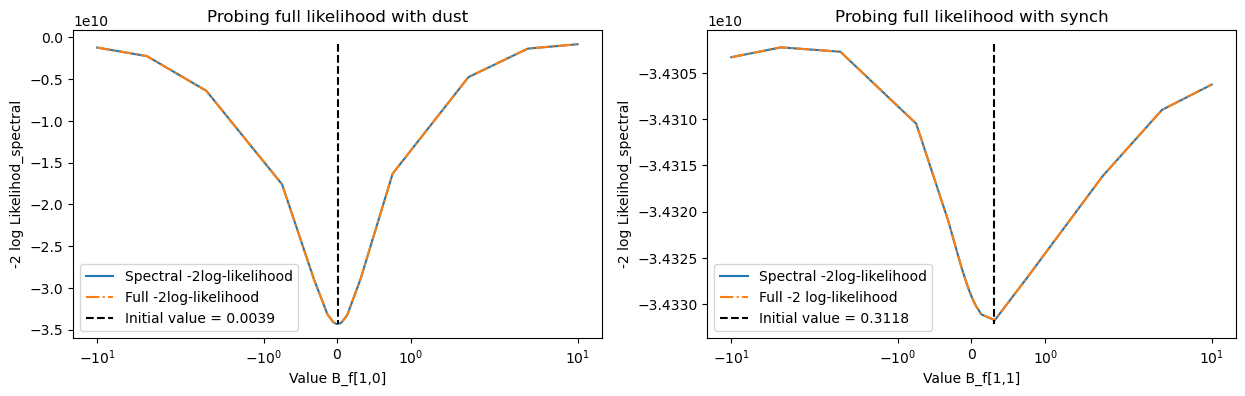

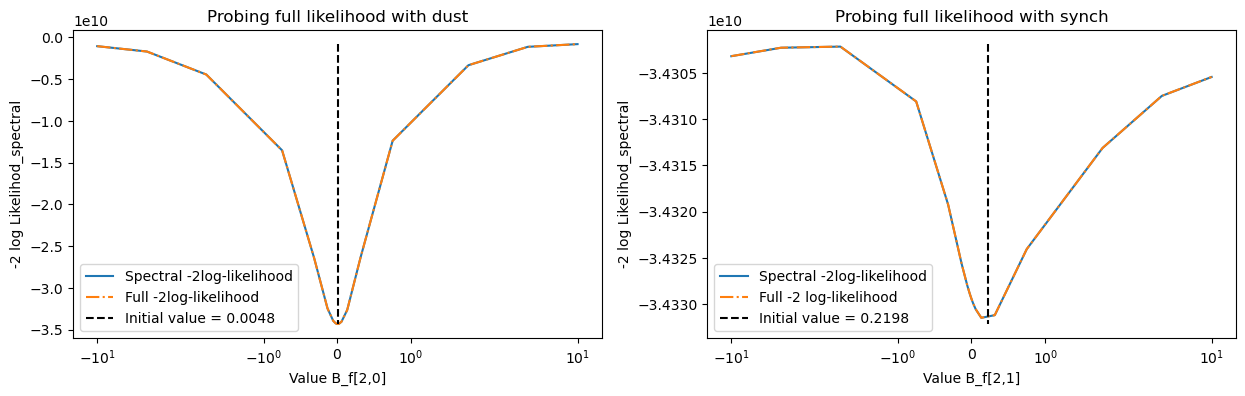

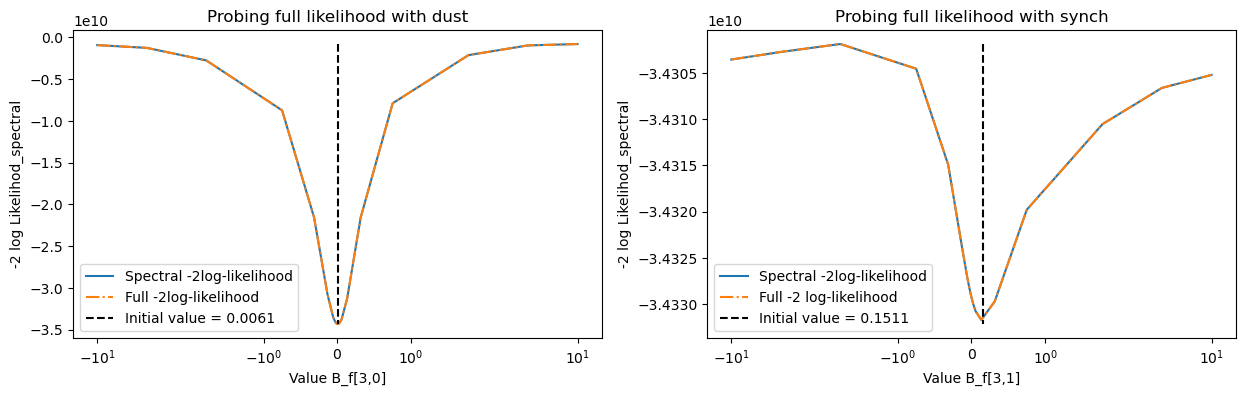

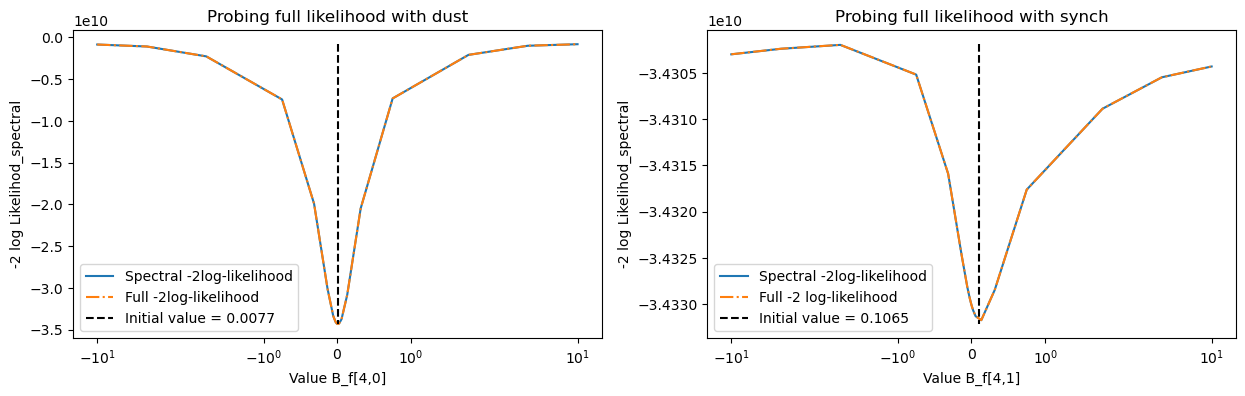

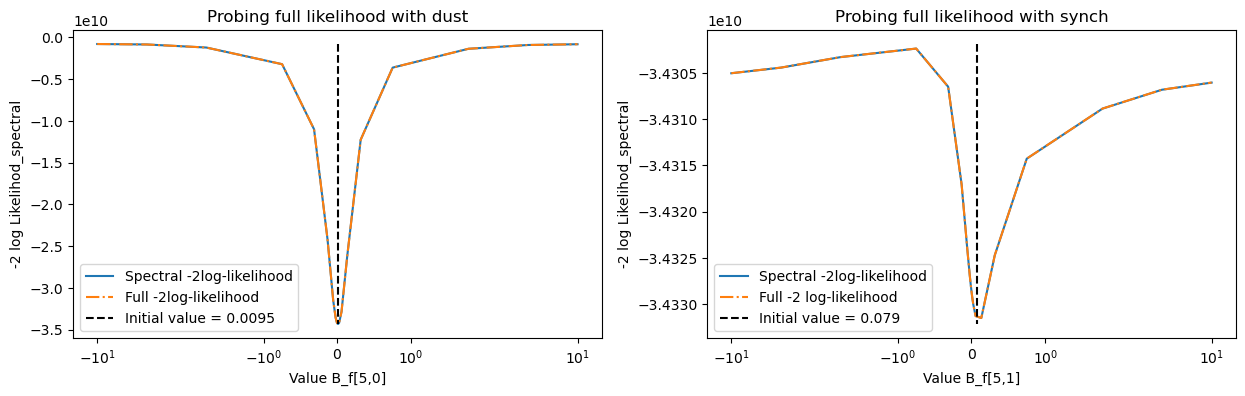

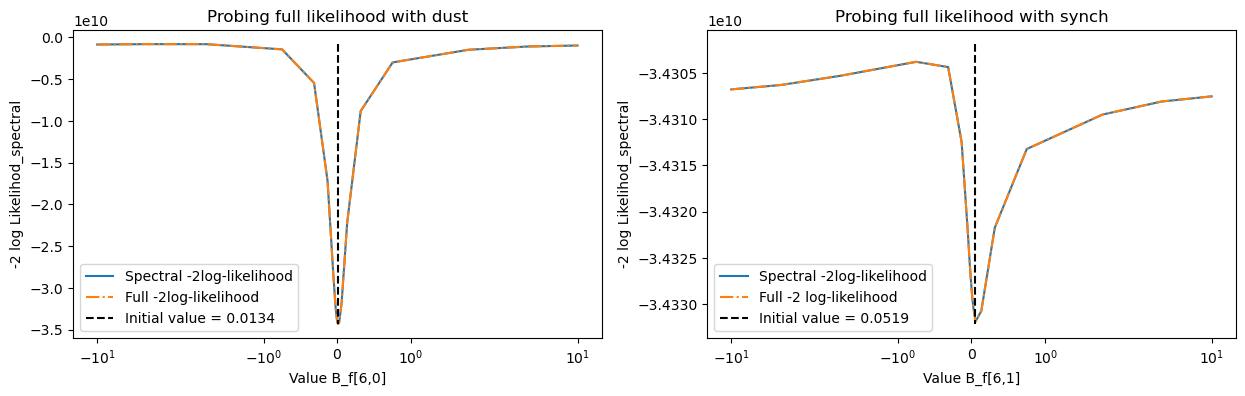

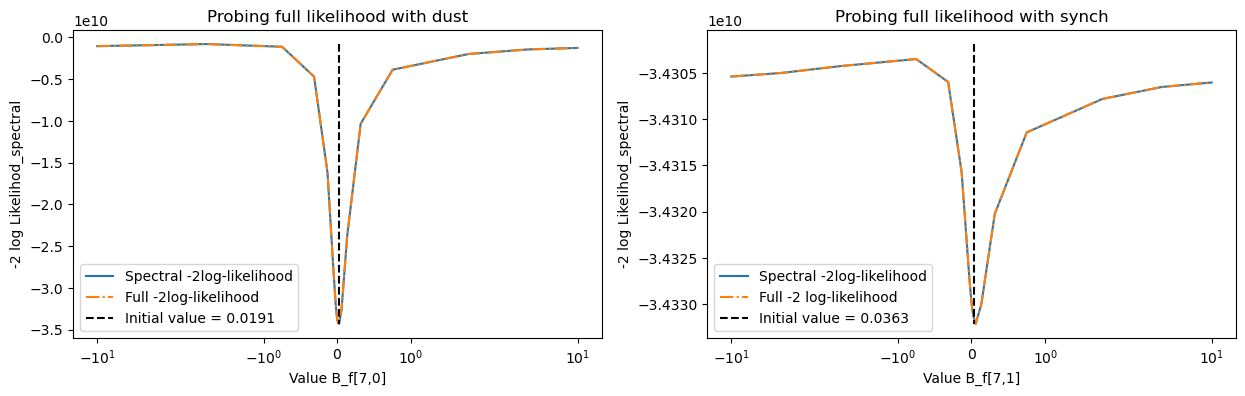

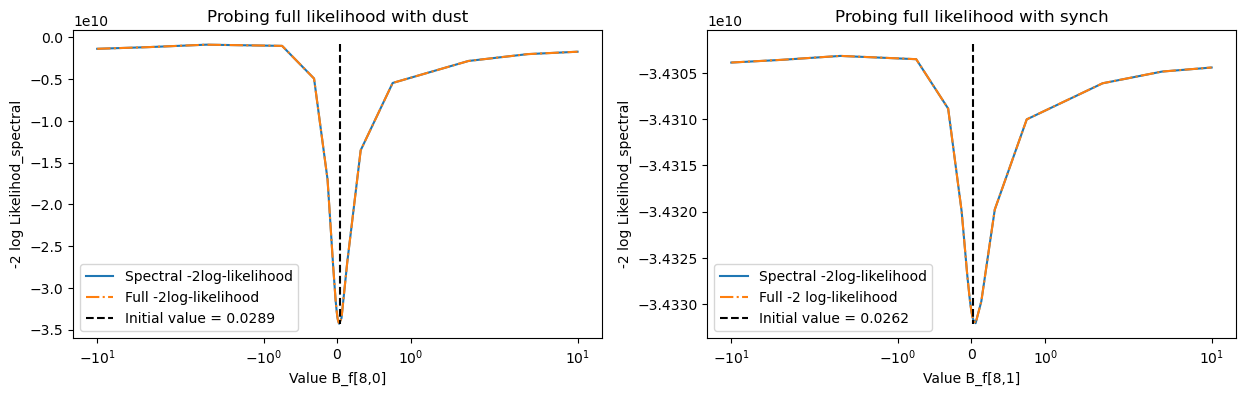

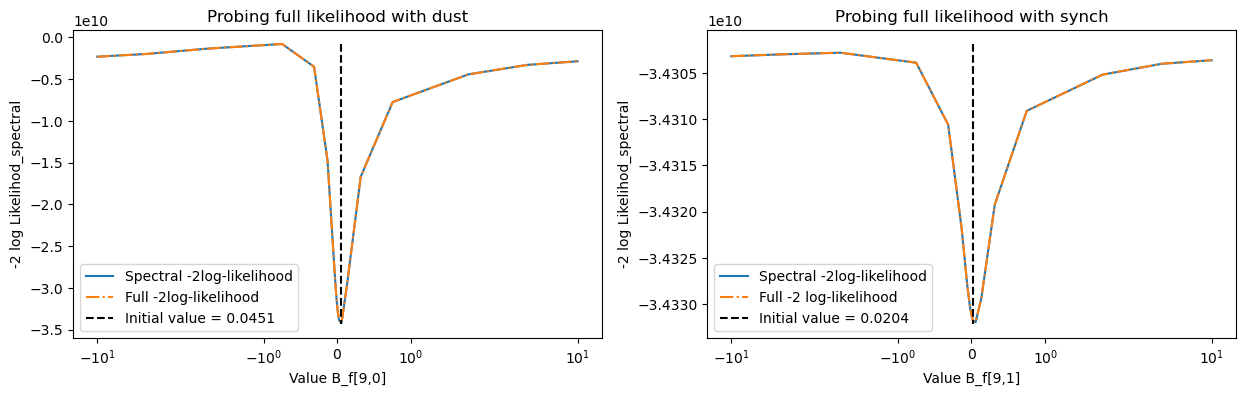

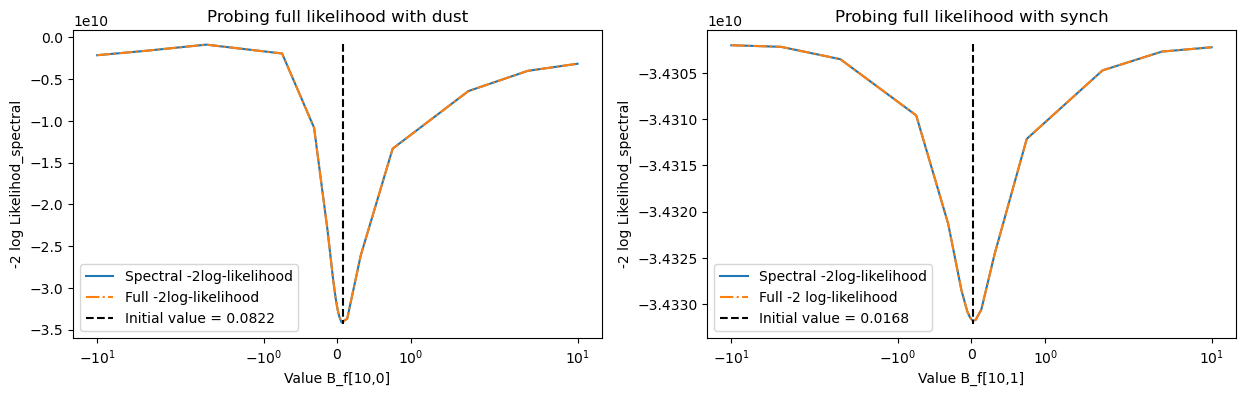

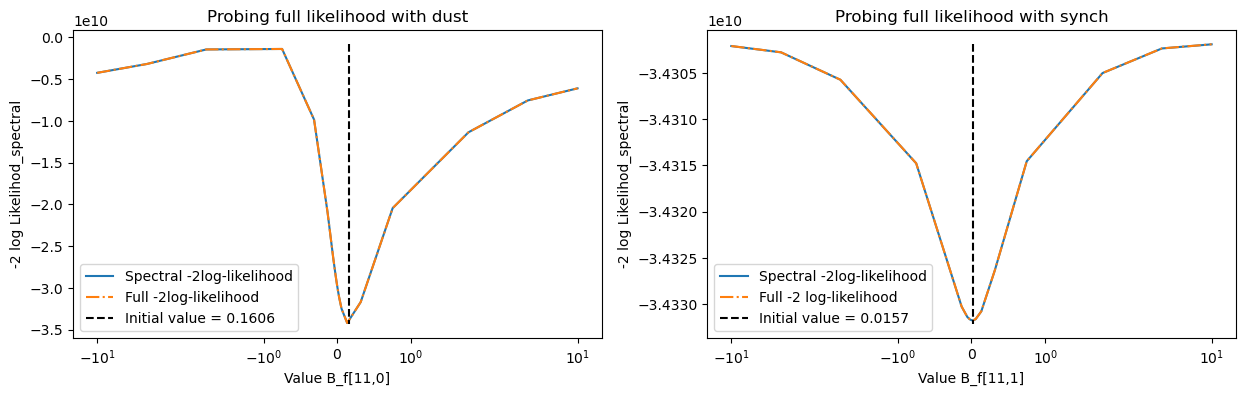

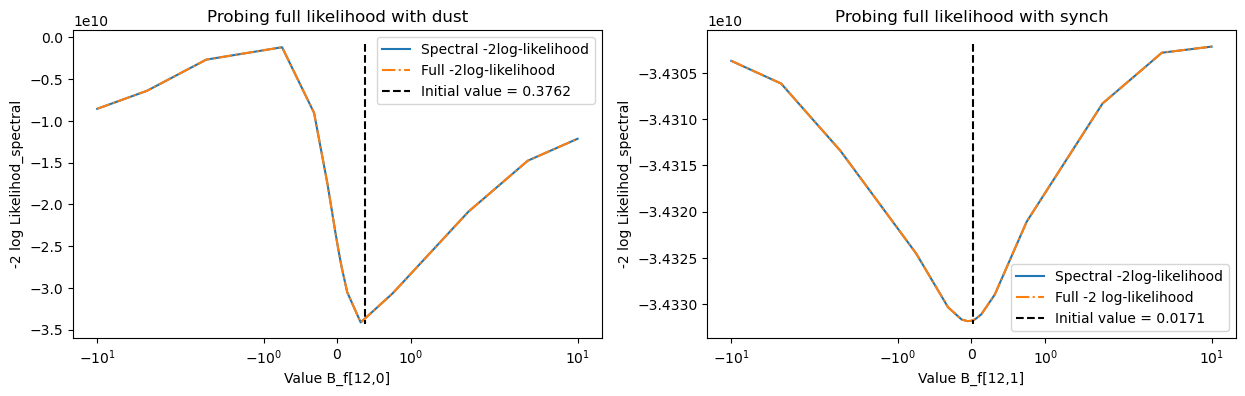

In [63]:
log_proba_griding_dust = np.array(log_proba_samples_dust_list)-regularization_constant
log_proba_griding_synch = np.array(log_proba_samples_synch_list)-regularization_constant

log_proba_griding_dust_full = np.array(log_proba_samples_dust_full_proba)-regularization_constant
log_proba_griding_synch_full = np.array(log_proba_samples_synch_full_proba)-regularization_constant

# number_subplot = (number_frequencies-2)*100 + 20
n_decimals = 4
for freq_coord in range(number_frequencies-2):
    plt.figure(figsize=(15,4))
    initial_value = init_params[freq_coord, cpt_coord]
    initial_value_rounded = np.round(initial_value, decimals=n_decimals)
    # plt.subplot((number_frequencies-2,2,freq_coord*2))
    plt.subplot(121)
    # min_value = (-2*log_proba_griding_dust[freq_coord,:]).min()
    plt.plot(griding_logspace, -2*log_proba_griding_dust[freq_coord,:], label='Spectral -2log-likelihood')
    plt.plot(griding_logspace, -2*log_proba_griding_dust_full[freq_coord,:], '-.', label='Full -2log-likelihood')
    # for freq_coord in range(number_frequencies-2):
    #     plt.plot(griding_logspace, -2*log_proba_griding.T, '--', alpha=.1)

    plt.plot([initial_value,initial_value], [-2*log_proba_griding_dust_full.min(),-2*log_proba_griding_dust_full.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [0,((-2*log_proba_griding_dust[freq_coord,:]).max()-min_value).max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))

    plt.xscale('symlog')
    plt.xlabel('Value B_f[{},{}]'.format(freq_coord, cpt_coord))
    plt.ylabel('-2 log Likelihod_spectral')
    plt.title('Probing full likelihood with dust')
    plt.legend()

    initial_value = init_params[freq_coord, cpt_coord+1]
    initial_value_rounded = np.round(initial_value, decimals=n_decimals)
    # plt.subplot((number_frequencies-2,2,freq_coord*2+1))
    plt.subplot(122)
    plt.plot(griding_logspace, -2*log_proba_griding_synch[freq_coord,:], label='Spectral -2log-likelihood')
    plt.plot(griding_logspace, -2*log_proba_griding_synch_full[freq_coord,:], '-.', label='Full -2 log-likelihood')
    # for freq_coord in range(number_frequencies-2):
    #     plt.plot(griding_logspace, -2*log_proba_griding.T, '--', alpha=.1)

    plt.plot([initial_value,initial_value], [-2*log_proba_griding_synch_full.min(),-2*log_proba_griding_synch_full.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    plt.xscale('symlog')
    plt.xlabel('Value B_f[{},{}]'.format(freq_coord, cpt_coord+1))
    plt.ylabel('-2 log Likelihod_spectral')
    plt.title('Probing full likelihood with synch')
    plt.legend()
    plt.show()


## Fine griding

In [64]:
np.arange(-5,5,.2)

array([-5.0000000e+00, -4.8000000e+00, -4.6000000e+00, -4.4000000e+00,
       -4.2000000e+00, -4.0000000e+00, -3.8000000e+00, -3.6000000e+00,
       -3.4000000e+00, -3.2000000e+00, -3.0000000e+00, -2.8000000e+00,
       -2.6000000e+00, -2.4000000e+00, -2.2000000e+00, -2.0000000e+00,
       -1.8000000e+00, -1.6000000e+00, -1.4000000e+00, -1.2000000e+00,
       -1.0000000e+00, -8.0000000e-01, -6.0000000e-01, -4.0000000e-01,
       -2.0000000e-01,  4.4408921e-15,  2.0000000e-01,  4.0000000e-01,
        6.0000000e-01,  8.0000000e-01,  1.0000000e+00,  1.2000000e+00,
        1.4000000e+00,  1.6000000e+00,  1.8000000e+00,  2.0000000e+00,
        2.2000000e+00,  2.4000000e+00,  2.6000000e+00,  2.8000000e+00,
        3.0000000e+00,  3.2000000e+00,  3.4000000e+00,  3.6000000e+00,
        3.8000000e+00,  4.0000000e+00,  4.2000000e+00,  4.4000000e+00,
        4.6000000e+00,  4.8000000e+00])

In [65]:
# griding_logspace = np.logspace(-10,10)
# griding_logspace_fine = np.concatenate((np.flip(-np.logspace(-8,1,num=25)), np.logspace(-8,1,num=25)))
griding_logspace_fine = np.empty((2, number_frequencies-2, 50))

# log_proba_griding = []
# log_proba_samples_list = [jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace]
log_proba_samples_dust_list_fine = np.empty((number_frequencies-2, griding_logspace.shape[0]))
log_proba_samples_synch_list_fine = np.empty((number_frequencies-2, griding_logspace.shape[0]))
for freq_coord in range(number_frequencies-2):
    initial_value = init_params[freq_coord, 0]
    griding_logspace_fine[0,freq_coord,...] = np.arange(-5,5,.2)*minimum_std_Fisher_diag[freq_coord] + initial_value
    log_proba_samples_dust_list_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace_fine[0,freq_coord,...]])
    initial_value = init_params[freq_coord, 1]
    griding_logspace_fine[1,freq_coord,...] = np.arange(-5,5,.2)*minimum_std_Fisher_diag[freq_coord + number_frequencies-2] + initial_value
    log_proba_samples_synch_list_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace_fine[1,freq_coord,...]])


log_proba_samples_dust_full_proba_fine = np.empty((number_frequencies-2, griding_logspace.shape[0]))
log_proba_samples_synch_full_proba_fine = np.empty((number_frequencies-2, griding_logspace.shape[0]))
for freq_coord in range(number_frequencies-2):
    print("Nb freq :", freq_coord, number_frequencies-2)
    log_proba_samples_dust_full_proba_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_full_likelihood_JAX(value_param, freq_coord, cpt_coord, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace_fine[0,freq_coord,...]])
    print("Nb freq n°2 :", freq_coord, number_frequencies-2)
    log_proba_samples_synch_full_proba_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_full_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace_fine[1,freq_coord,...]])

Nb freq : 0 13
Nb freq n°2 : 0 13
Nb freq : 1 13
Nb freq n°2 : 1 13
Nb freq : 2 13
Nb freq n°2 : 2 13
Nb freq : 3 13
Nb freq n°2 : 3 13
Nb freq : 4 13
Nb freq n°2 : 4 13
Nb freq : 5 13
Nb freq n°2 : 5 13
Nb freq : 6 13
Nb freq n°2 : 6 13
Nb freq : 7 13
Nb freq n°2 : 7 13
Nb freq : 8 13
Nb freq n°2 : 8 13
Nb freq : 9 13
Nb freq n°2 : 9 13
Nb freq : 10 13
Nb freq n°2 : 10 13
Nb freq : 11 13
Nb freq n°2 : 11 13
Nb freq : 12 13
Nb freq n°2 : 12 13


In [66]:
np.diag(minimum_std_Fisher), minimum_std_Fisher_diag

(array([1.29324268e-03, 9.62148633e-04, 7.62460177e-04, 6.23283957e-04,
        5.36182447e-04, 4.29689251e-04, 3.62604834e-04, 2.96497747e-04,
        3.19329897e-04, 2.94524649e-04, 3.75601363e-04, 6.23341646e-04,
        1.02018086e-03, 4.95614237e-05, 3.68731309e-05, 2.92207210e-05,
        2.38873861e-05, 2.05496919e-05, 1.64688905e-05, 1.38983823e-05,
        1.13653364e-05, 1.22402409e-05, 1.12896537e-05, 1.43962019e-05,
        2.38896043e-05, 3.90970393e-05, 9.22799496e-05]),
 array([4.95614237e-05, 3.68731309e-05, 2.92207210e-05, 2.38873861e-05,
        2.05496919e-05, 1.64688905e-05, 1.38983823e-05, 1.13653364e-05,
        1.22402409e-05, 1.12896537e-05, 1.43962019e-05, 2.38896043e-05,
        3.90970393e-05, 1.29324268e-03, 9.62148633e-04, 7.62460177e-04,
        6.23283957e-04, 5.36182447e-04, 4.29689251e-04, 3.62604834e-04,
        2.96497747e-04, 3.19329897e-04, 2.94524649e-04, 3.75601363e-04,
        6.23341646e-04, 1.02018086e-03]))

In [67]:
%%time

freq_coord = 0
initial_value = init_params[freq_coord, cpt_coord+1]
griding_logspace_fine[1,freq_coord,...] = np.arange(-5,5,.2)*minimum_std_Fisher_diag[freq_coord + number_frequencies-2] + initial_value
# griding_logspace_fine[1,freq_coord,...] = np.linspace(-5000,5,num=50)*np.diag(minimum_std_Fisher)[freq_coord + number_frequencies-2] + initial_value
log_proba_samples_synch_list_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_spectral_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace_fine[1,freq_coord,...]])
log_proba_samples_synch_full_proba_fine[freq_coord,...] = np.array([jitted_new_get_conditional_proba_full_likelihood_JAX(value_param, freq_coord, cpt_coord+1, pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for value_param in griding_logspace_fine[1,freq_coord,...]])

CPU times: user 2min 33s, sys: 19.8 s, total: 2min 53s
Wall time: 57.9 s


/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


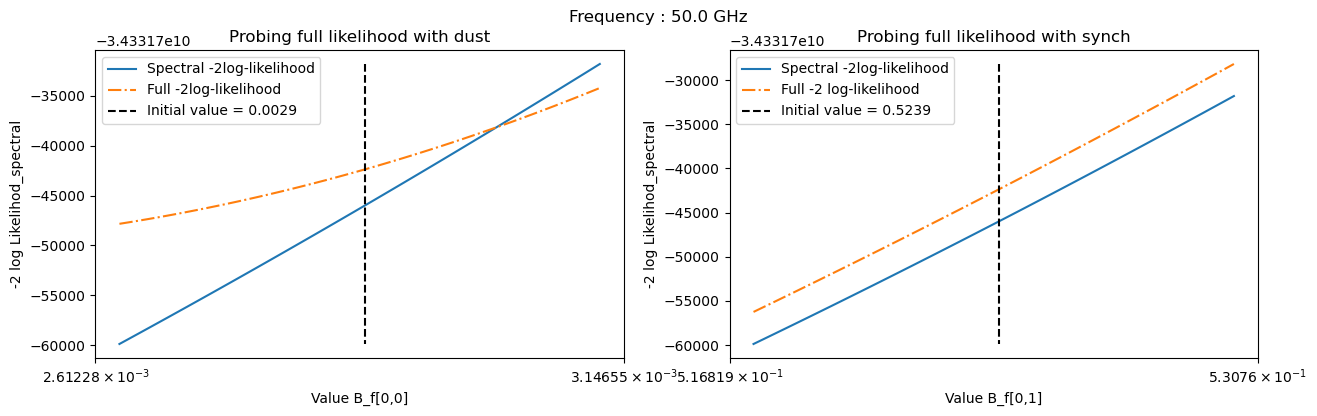

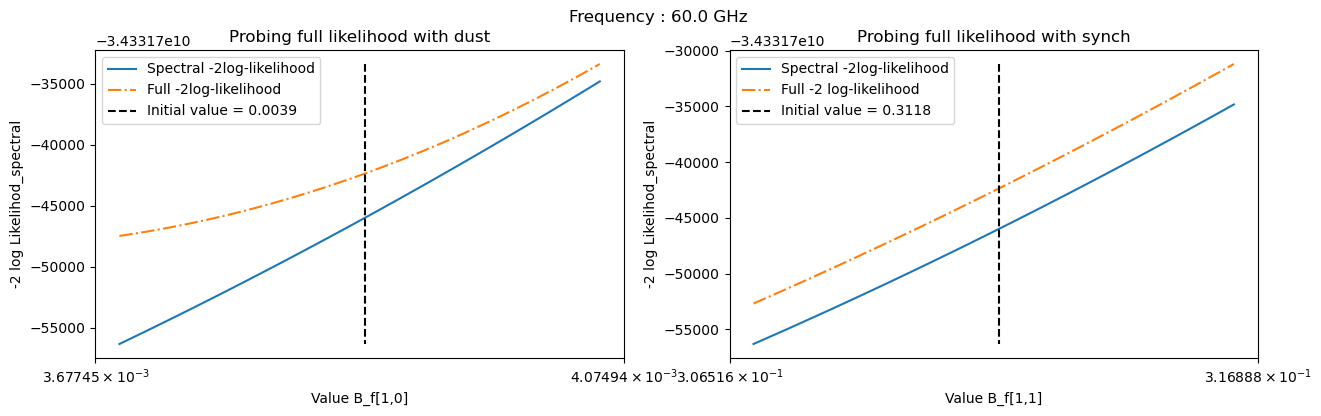

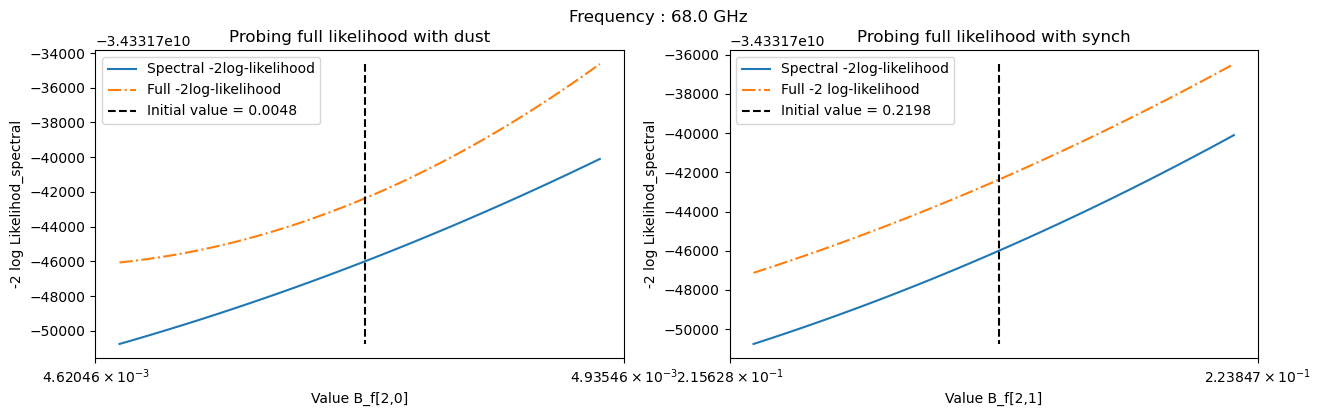

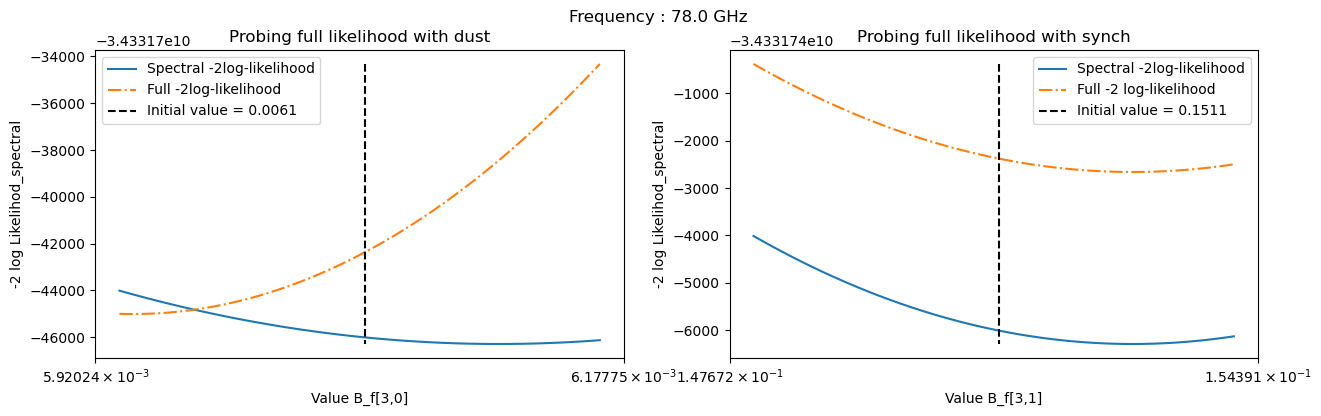

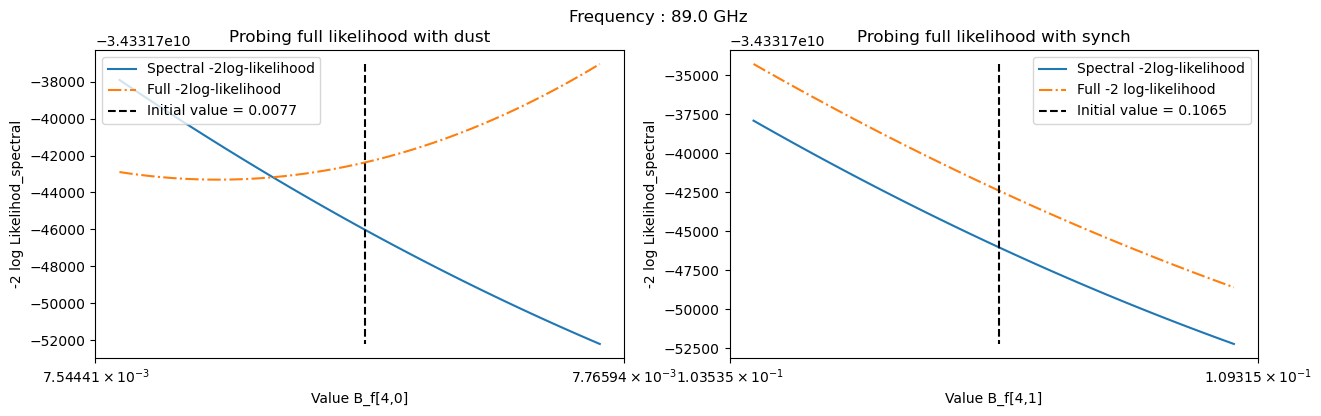

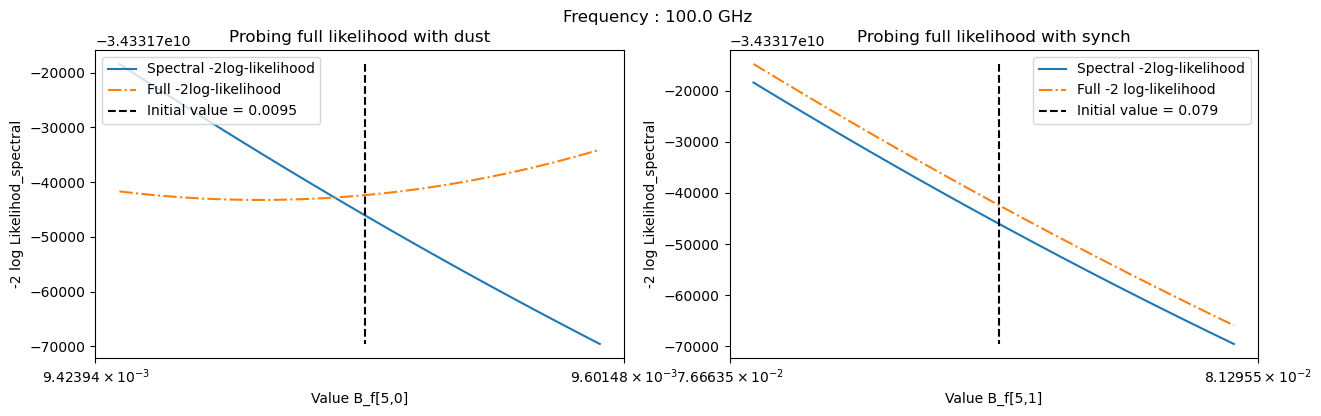

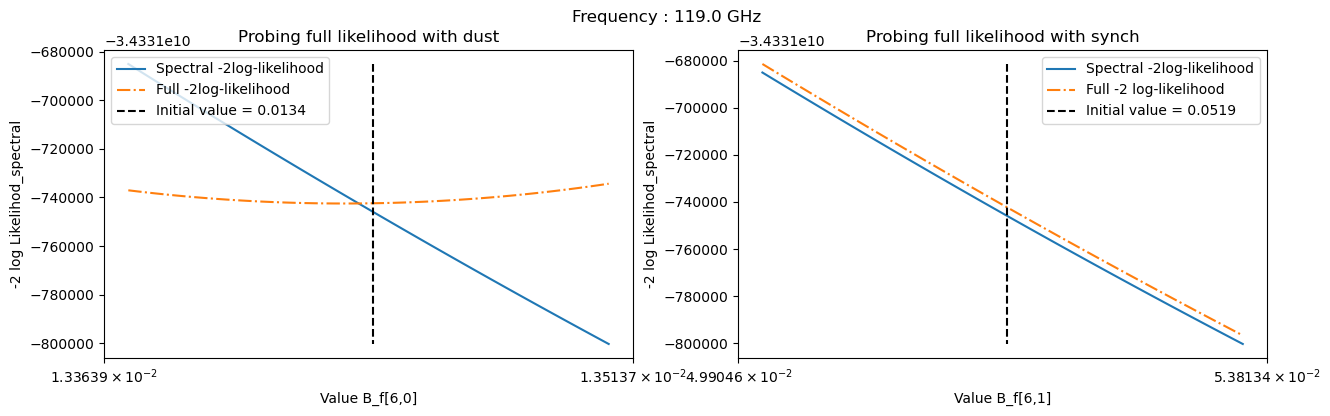

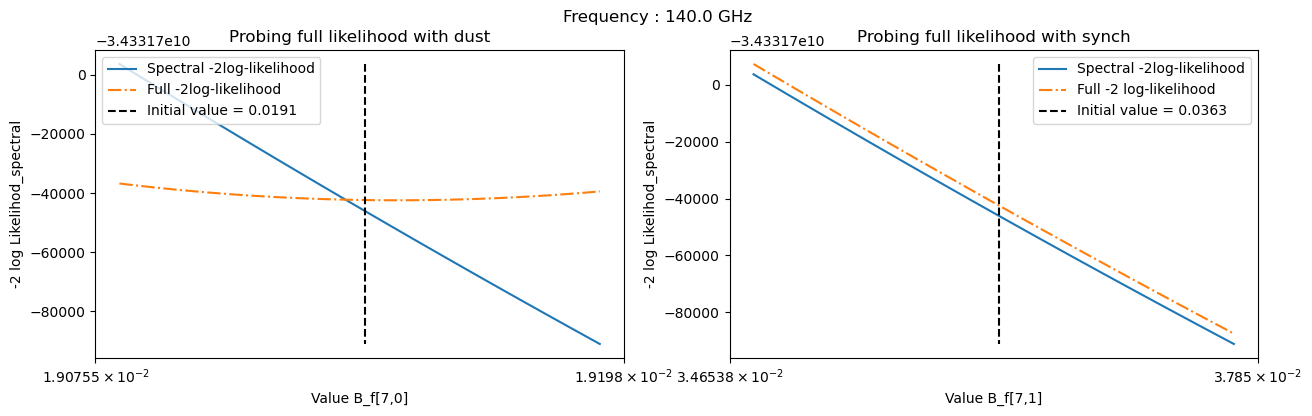

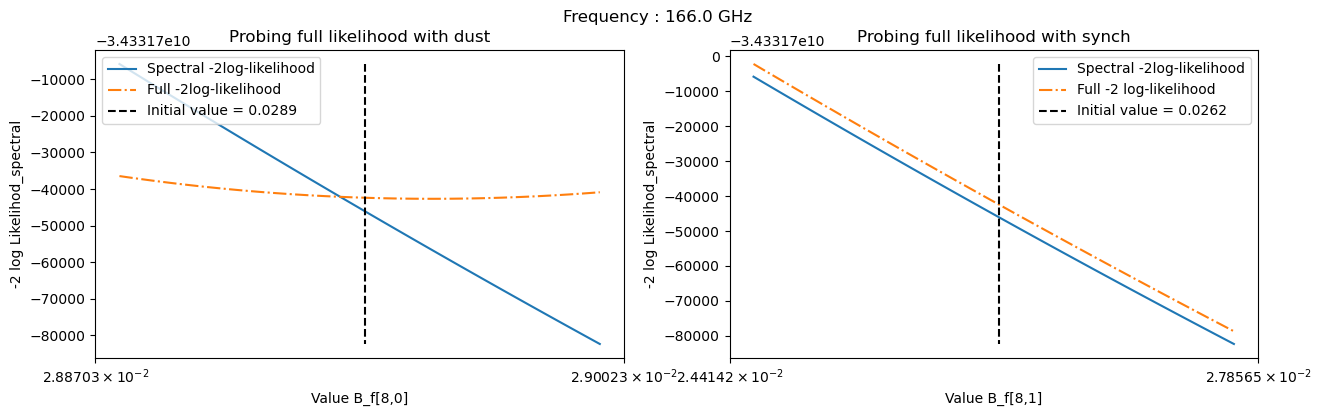

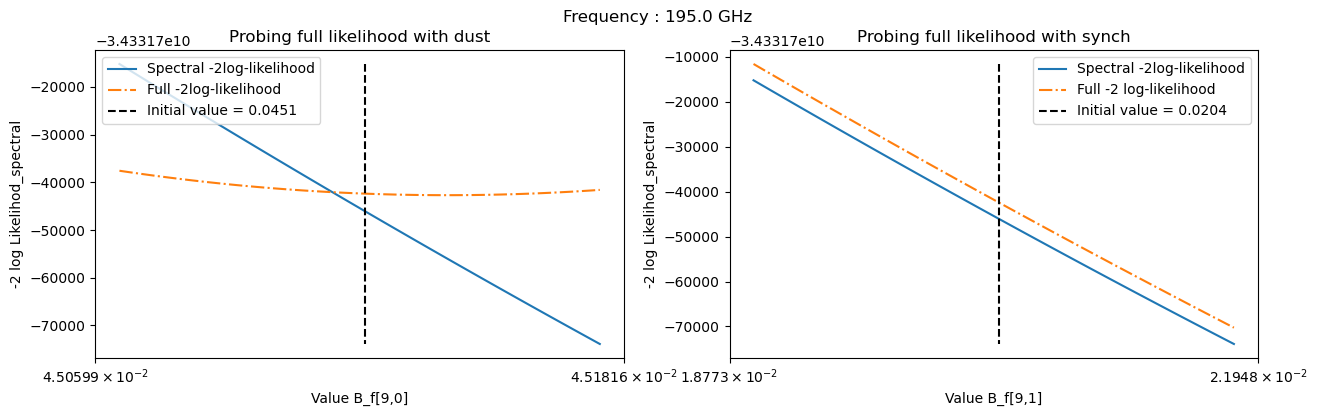

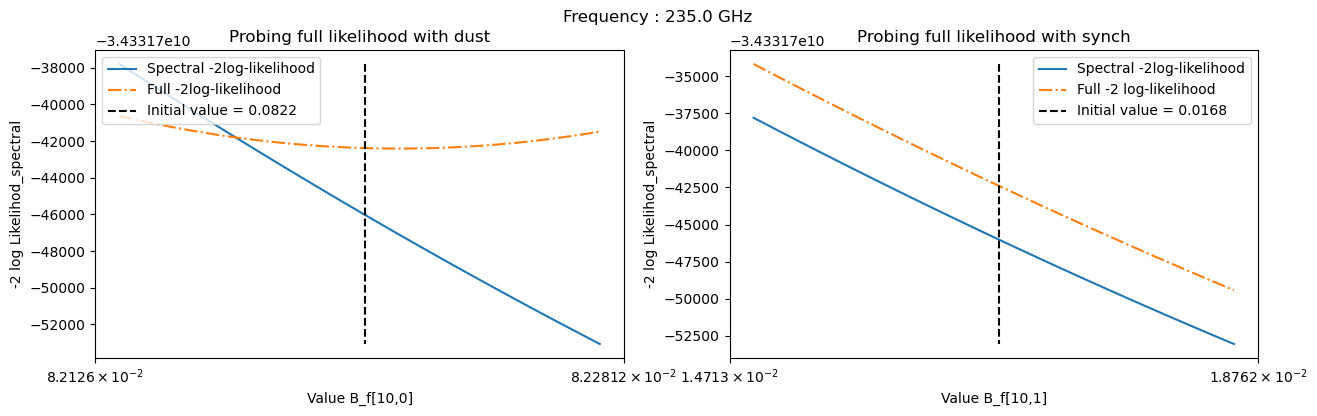

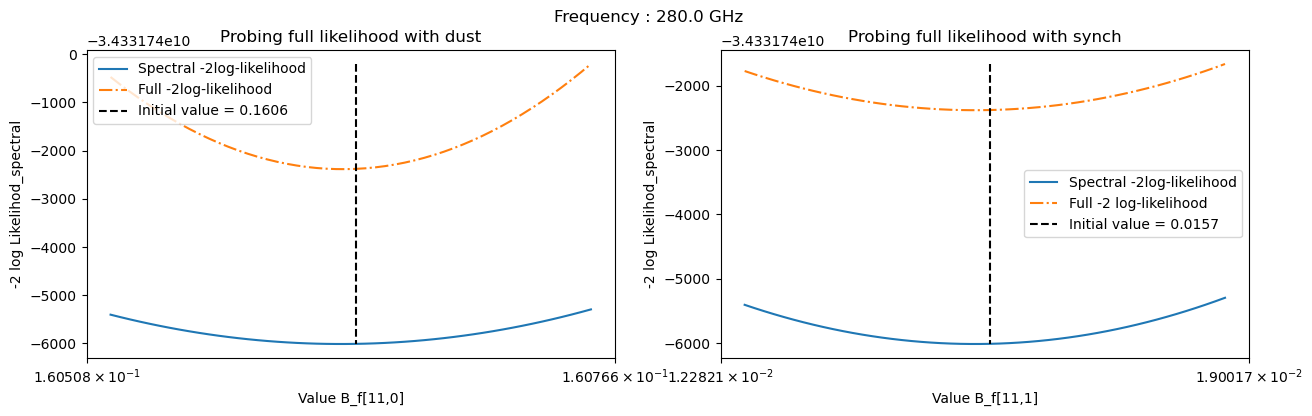

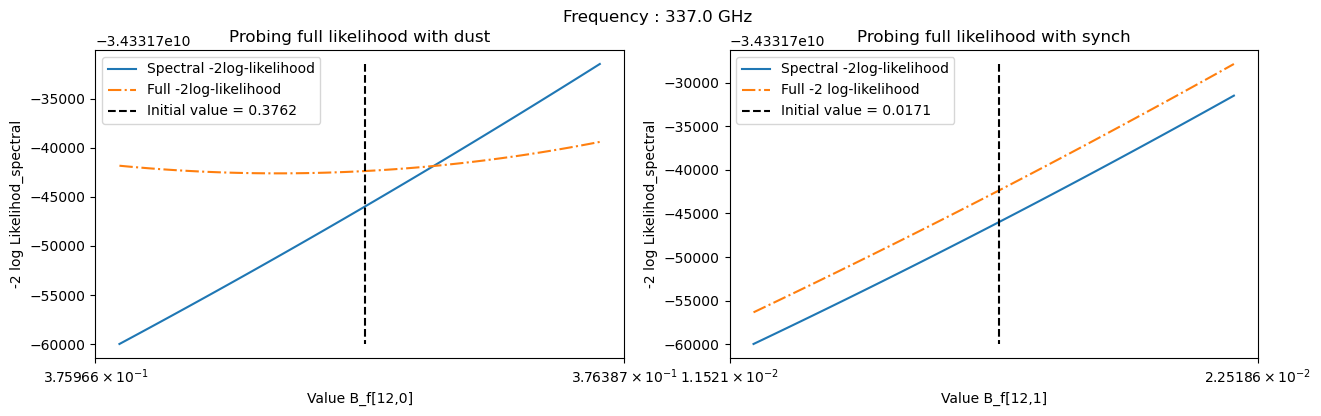

In [68]:
log_proba_griding_dust_fine = np.array(log_proba_samples_synch_list_fine)-regularization_constant
log_proba_griding_synch_fine = np.array(log_proba_samples_synch_list_fine)-regularization_constant

log_proba_griding_dust_full_fine = np.array(log_proba_samples_dust_full_proba_fine)-regularization_constant
log_proba_griding_synch_full_fine = np.array(log_proba_samples_synch_full_proba_fine)-regularization_constant

nb_Fisher = 5

# number_subplot = (number_frequencies-2)*100 + 20
n_decimals = 4
for freq_coord in range(number_frequencies-2):
    plt.figure(figsize=(15,4))
    plt.suptitle('Frequency : {} GHz'.format(frequency_Bf[freq_coord+1]))
    initial_value = init_params[freq_coord, cpt_coord]
    initial_value_rounded = np.round(initial_value, decimals=n_decimals)
    # plt.subplot((number_frequencies-2,2,freq_coord*2))
    plt.subplot(121)
    # min_value = (-2*log_proba_griding_dust[freq_coord,:]).min()
    plt.plot(griding_logspace_fine[0,freq_coord], -2*log_proba_griding_dust_fine[freq_coord,:], label='Spectral -2log-likelihood')
    plt.plot(griding_logspace_fine[0,freq_coord], -2*log_proba_griding_dust_full_fine[freq_coord,:], '-.', label='Full -2log-likelihood')
    # for freq_coord in range(number_frequencies-2):
    #     plt.plot(griding_logspace, -2*log_proba_griding.T, '--', alpha=.1)

    min_value = max(-2*log_proba_griding_dust_fine[freq_coord,:].min(),-2*log_proba_griding_dust_full_fine[freq_coord,:].min())
    max_value = min(-2*log_proba_griding_dust_fine[freq_coord,:].max(),-2*log_proba_griding_dust_full_fine[freq_coord,:].max())
    # plt.plot([initial_value,initial_value], [-2*log_proba_griding_dust_full_fine.min(),-2*log_proba_griding_dust_full_fine.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    plt.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [0,((-2*log_proba_griding_dust[freq_coord,:]).max()-min_value).max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))


    # sigma_B_f = nb_Fisher*np.diag(minimum_std_Fisher)[freq_coord]
    # half_value = -np.median(log_proba_griding_dust[freq_coord,:])/2
    # plt.plot([initial_value-sigma_B_f,initial_value+sigma_B_f], [half_value,half_value], 'r', label=r"$\sigma (B_{f})$"+f"~{percent_value}%")
    # plt.plot([initial_value-sigma_B_f,initial_value+sigma_B_f], [half_value,half_value], 'r', label=f"{nb_Fisher}"+r"$\sigma_{Fisher}$")

    plt.xscale('symlog')
    plt.xlabel('Value B_f[{},{}]'.format(freq_coord, cpt_coord))
    plt.ylabel('-2 log Likelihod_spectral')
    plt.title('Probing full likelihood with dust')
    # xmin = initial_value - sigma_B_f
    # xmax = initial_value + sigma_B_f
    # log_proba_to_consider = -2*log_proba_griding_dust[freq_coord,:]
    # bounds = log_proba_to_consider[np.logical_and(griding_logspace>xmin,griding_logspace<xmax)]
    # plt.xlim(xmin=xmin, xmax=xmax)
    # plt.ylim(ymin=bounds.min(), ymax=bounds.max())
    plt.legend(loc='upper left')

    initial_value = init_params[freq_coord, cpt_coord+1]
    initial_value_rounded = np.round(initial_value, decimals=n_decimals)
    # plt.subplot((number_frequencies-2,2,freq_coord*2+1))
    plt.subplot(122)
    plt.plot(griding_logspace_fine[1,freq_coord], -2*log_proba_griding_synch_fine[freq_coord,:], label='Spectral -2log-likelihood')
    plt.plot(griding_logspace_fine[1,freq_coord], -2*log_proba_griding_synch_full_fine[freq_coord,:], '-.', label='Full -2 log-likelihood')
    # for freq_coord in range(number_frequencies-2):
    #     plt.plot(griding_logspace, -2*log_proba_griding.T, '--', alpha=.1)

    min_value = max(-2*log_proba_griding_synch_fine[freq_coord,:].min(),-2*log_proba_griding_synch_full_fine[freq_coord,:].min())
    max_value = min(-2*log_proba_griding_synch_fine[freq_coord,:].max(),-2*log_proba_griding_synch_full_fine[freq_coord,:].max())
    # plt.plot([initial_value,initial_value], [-2*log_proba_griding_synch_full.min(),-2*log_proba_griding_synch_full.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    # plt.plot([initial_value,initial_value], [-2*log_proba_griding_synch_full_fine.min(),-2*log_proba_griding_synch_full_fine.max()], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    plt.plot([initial_value,initial_value], [min_value,max_value], 'k--', label='Initial value = {}'.format(initial_value_rounded))
    plt.xscale('symlog')
    plt.xlabel('Value B_f[{},{}]'.format(freq_coord, cpt_coord+1))
    plt.ylabel('-2 log Likelihod_spectral')
    plt.title('Probing full likelihood with synch')
    # plt.xlim(xmin=.5*initial_value, xmax=1.5*initial_value)
    plt.legend()
    plt.show()


# MCMC

In [29]:
with_prints = False

number_steps_sampler = 10000
n_walkers = 1

kernel = MetropolisHastings_log(new_get_conditional_proba_spectral_likelihood_JAX, step_size=0.1)
# kernel = MetropolisHastings(new_get_conditional_proba_spectral_likelihood_JAX, step_size=0.1)
# kernel = MetropolisHastings(new_get_conditional_proba_spectral_likelihood_JAX, step_size=0.5)
# kernel = MetropolisHastings(jitted_new_get_conditional_proba_spectral_likelihood_JAX, step_size=0.5)
mcmc = MCMC(kernel, num_chains=n_walkers, num_warmup=0, num_samples=number_steps_sampler)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

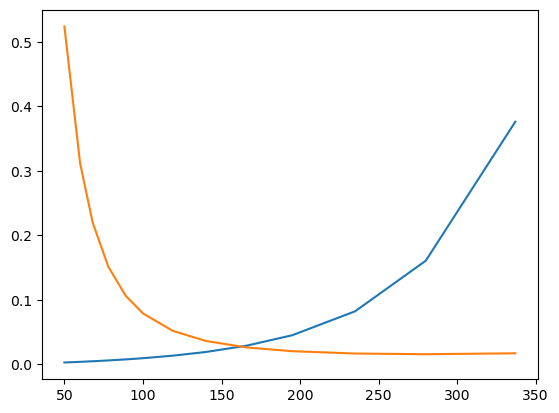

In [43]:
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T, label='init dust values')
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[int(dimensions_mixing_matrix/2):].T, label='init synchrotron values')

plt.plot(frequency_Bf, full_initial_guess[:,:int(dimensions_mixing_matrix/2)].T, '-.', label='init dust pre-sampling')
plt.plot(frequency_Bf, full_initial_guess[:,int(dimensions_mixing_matrix/2):].T, '-.', label='init synchrotron pre-sampling')
plt.loglog()
plt.legend()
plt.title('Initial guess values')
plt.show()

In [44]:
%%time 
mcmc.run(random.PRNGKey(0), init_params=full_initial_guess, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints, regularization_constant=regularization_constant)
samples = mcmc.get_samples(group_by_chain=True)
mcmc.print_summary()


sample: 100%|██████████| 50000/50000 [02:54<00:00, 287.22it/s]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 Param:0[0]      0.00      0.00      0.00      0.00      0.00      0.50      1.00
 Param:0[1]      0.00      0.00      0.00      0.00      0.00      0.50      1.00
 Param:0[2]      0.00      0.00      0.00      0.00      0.00      0.50      1.00
 Param:0[3]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
 Param:0[4]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
 Param:0[5]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
 Param:0[6]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
 Param:0[7]      0.02      0.00      0.02      0.02      0.02      0.50      1.00
 Param:0[8]      0.03      0.00      0.03      0.03      0.03      0.50      1.00
 Param:0[9]      0.05      0.00      0.05      0.05      0.05      0.50      1.00
Param:0[10]      0.08      0.00      0.08      0.08      0.08      0.50      1.00
Param:0[11]    

In [45]:
samples.shape

(1, 50000, 26)

In [47]:
# log_proba_samples_list = [jitted_new_get_conditional_proba_spectral_likelihood_JAX(samples[0,i,0,:], pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for i in range(number_steps_sampler)]
log_proba_samples_list = [jitted_new_get_conditional_proba_spectral_likelihood_JAX(samples[0,i,:], pos_special_freqs=mixing_matrix_obj.pos_special_freqs, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant) for i in range(number_steps_sampler)]

In [48]:
log_proba_samples = np.array(log_proba_samples_list)/log_proba_samples_list[0]

In [50]:
# number_element_column = int(samples.shape[2]/2)

number_element_column = int(samples.shape[-1]/2)
# component_dust = samples[:,:,:,:number_element_column].reshape(number_steps_sampler, number_element_column)
# component_synchrotron = samples[:,:,:,number_element_column:].reshape(number_steps_sampler, number_element_column)
# # component_synchrotron = samples[:,:,:,number_element_column:].reshape(number_steps_sampler, number_element_column, order='F')

component_dust = samples[:,:,:number_element_column].reshape(number_steps_sampler, number_element_column)
component_synchrotron = samples[:,:,number_element_column:].reshape(number_steps_sampler, number_element_column)


print(component_dust.shape)

(50000, 13)


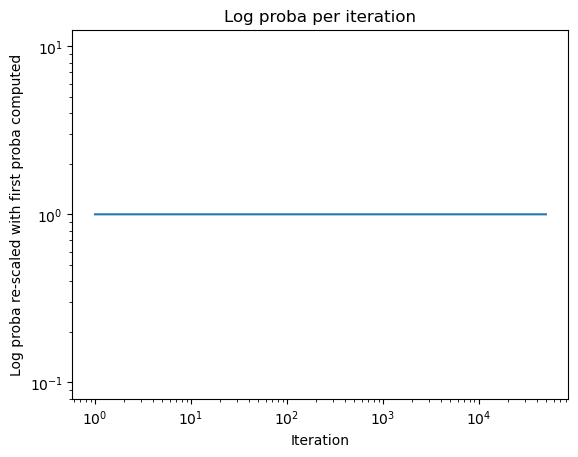

In [51]:
plt.plot(np.arange(number_steps_sampler)+1, log_proba_samples)
plt.title('Log proba per iteration')
plt.xlabel('Iteration')
plt.ylabel('Log proba re-scaled with first proba computed')
plt.loglog()
plt.show()

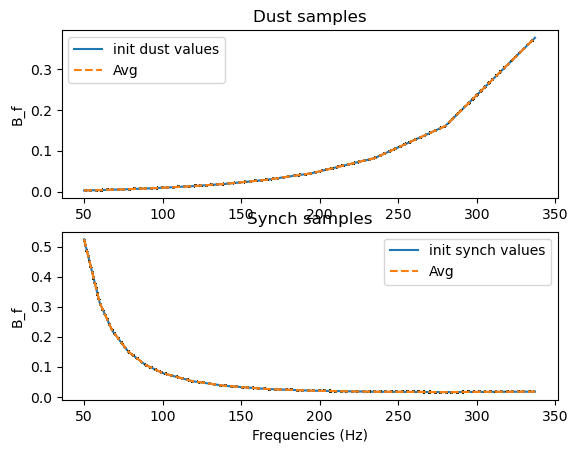

In [52]:
frequency_Bf = instrument['frequency'][1:-1]

plt.subplot(211)
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T, label='init dust values')
plt.plot(frequency_Bf, component_dust.T, ':', alpha=0.1)
plt.plot(frequency_Bf, component_dust.mean(axis=0), '--', label='Avg')
# plt.plot(frequency_Bf, component_dust[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_dust[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_dust[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('Dust samples')
# plt.loglog()
plt.legend()
# plt.xlabel('Frequencies (Hz)')
plt.ylabel('B_f')

plt.subplot(212)
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[int(dimensions_mixing_matrix/2):].T, label='init synch values')
plt.plot(frequency_Bf, component_synchrotron.T, ':', alpha=0.1)
plt.plot(frequency_Bf, component_synchrotron.mean(axis=0), '--', label='Avg')
# plt.plot(frequency_Bf, component_dust[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_dust[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_dust[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('Synch samples')
# plt.loglog()
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('B_f')
plt.show()

In [53]:
number_element_column = int(samples.shape[-1]/2)


# all_ess = numpyro.diagnostics.effective_sample_size(samples[:,:,0,:])
all_ess = numpyro.diagnostics.effective_sample_size(samples[:,:,:])
print(all_ess.shape)
print(all_ess)

int_ess = np.where(np.int32(np.round(all_ess)) == 0, 1, np.int32(np.round(all_ess)))

all_samples_ESS = []
all_avg_ESS = np.empty(samples.shape[-1])
for i in range(samples.shape[-1]):
    # all_samples_ESS.append(samples[0,::int_ess[i],0,i])
    # all_avg_ESS[i] = np.average(samples[0,::int_ess[i],0,i])
    all_samples_ESS.append(samples[0,::int_ess[i],i])
    all_avg_ESS[i] = np.average(samples[0,::int_ess[i],i])


(26,)
[0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005
 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005
 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005 0.500005
 0.500005 0.500005]


In [54]:
for i in range(len(all_samples_ESS)):
    print('Std :', np.std(all_samples_ESS[i]))

Std : 3.903127820947816e-18
Std : 5.204170427930421e-18
Std : 1.734723475976807e-18
Std : 6.938893903907228e-18
Std : 3.469446951953614e-18
Std : 1.734723475976807e-18
Std : 1.9081958235744878e-17
Std : 2.42861286636753e-17
Std : 3.122502256758253e-17
Std : 0.0
Std : 1.1102230246251565e-16
Std : 1.3877787807814457e-16
Std : 1.1102230246251565e-16
Std : 7.771561172376096e-16
Std : 3.885780586188048e-16
Std : 1.6653345369377348e-16
Std : 0.0
Std : 5.551115123125783e-17
Std : 2.7755575615628914e-17
Std : 7.632783294297951e-17
Std : 4.163336342344337e-17
Std : 3.122502256758253e-17
Std : 0.0
Std : 1.734723475976807e-17
Std : 3.469446951953614e-18
Std : 1.734723475976807e-17


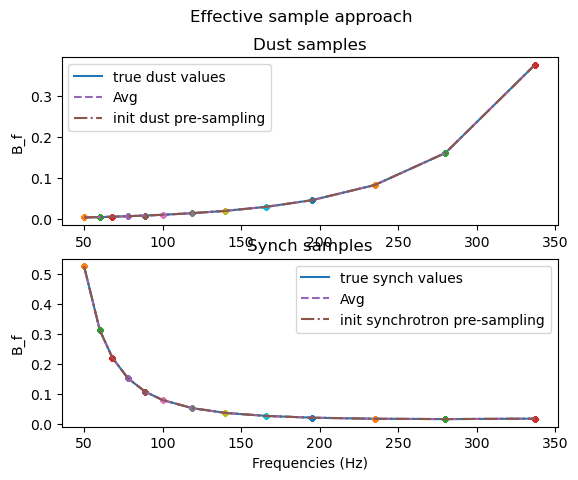

In [56]:
alpha_value = 0.5

frequency_Bf = instrument['frequency'][1:-1]
plt.suptitle("Effective sample approach")
plt.subplot(211)
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T, label='true dust values')
for i in range(number_element_column):
    # plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[i].shape[0]), all_samples_ESS[i], ':', alpha=alpha_value)
    plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[i].shape[0]), all_samples_ESS[i], '.', alpha=alpha_value)
plt.plot(frequency_Bf, all_avg_ESS[:number_element_column], '--', label='Avg')
plt.plot(frequency_Bf, full_initial_guess[:int(dimensions_mixing_matrix/2)].T, '-.', label='init dust pre-sampling')
# plt.plot(frequency_Bf, component_dust[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_dust[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_dust[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('Dust samples')
# plt.loglog()
plt.legend()
# plt.xlabel('Frequencies (Hz)')
plt.ylabel('B_f')

plt.subplot(212)
plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[int(dimensions_mixing_matrix/2):].T, label='true synch values')
for i in range(number_element_column):
    # plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[number_element_column+i].shape[0]), all_samples_ESS[number_element_column+i], ':', alpha=alpha_value)
    plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[number_element_column+i].shape[0]), all_samples_ESS[number_element_column+i], '.', alpha=alpha_value)
plt.plot(frequency_Bf, all_avg_ESS[number_element_column:], '--', label='Avg')
plt.plot(frequency_Bf, full_initial_guess[int(dimensions_mixing_matrix/2):].T, '-.', label='init synchrotron pre-sampling')
# plt.plot(frequency_Bf, component_dust[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_dust[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_dust[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('Synch samples')
# plt.loglog()
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('B_f')
plt.show()

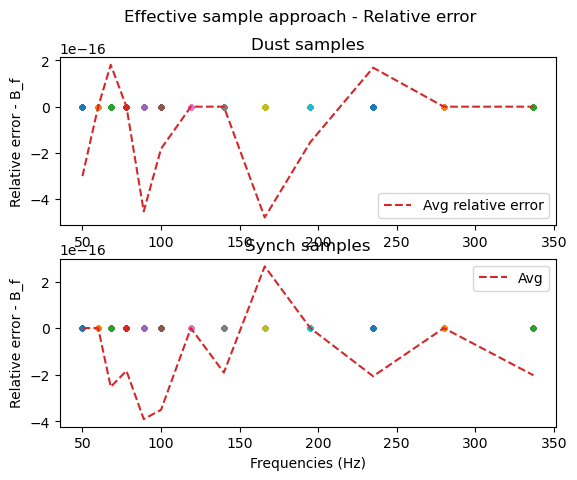

In [59]:
alpha_value = 0.5

frequency_Bf = instrument['frequency'][1:-1]
plt.suptitle("Effective sample approach - Relative error")
plt.subplot(211)
true_values = initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T
# plt.plot(frequency_Bf, initial_guess_fg_mixing_matrix[:int(dimensions_mixing_matrix/2)].T, label='true dust values')
for i in range(number_element_column):
    # plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[i].shape[0]), all_samples_ESS[i], ':', alpha=alpha_value)
    plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[i].shape[0]), (all_samples_ESS[i]-true_values[i])/true_values[i], '.', alpha=alpha_value)
plt.plot(frequency_Bf, (all_avg_ESS[:number_element_column]-true_values)/true_values, '--', label='Avg relative error')
# plt.plot(frequency_Bf, full_initial_guess[:,:int(dimensions_mixing_matrix/2)].T, '-.', label='init dust pre-sampling')
# plt.plot(frequency_Bf, component_dust[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_dust[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_dust[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('Dust samples')
# plt.loglog()
plt.legend()
# plt.xlabel('Frequencies (Hz)')
plt.ylabel('Relative error - B_f')

plt.subplot(212)
true_values = initial_guess_fg_mixing_matrix[int(dimensions_mixing_matrix/2):].T
# plt.plot(frequency_Bf, true_values, label='true synch values')
for i in range(number_element_column):
    # plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[number_element_column+i].shape[0]), all_samples_ESS[number_element_column+i], ':', alpha=alpha_value)
    plt.plot(frequency_Bf[i+1]*np.ones(all_samples_ESS[number_element_column+i].shape[0]), (all_samples_ESS[number_element_column+i]-true_values[i])/true_values[i], '.', alpha=alpha_value)
plt.plot(frequency_Bf, (all_avg_ESS[number_element_column:]-true_values)/true_values, '--', label='Avg')
# plt.plot(frequency_Bf, full_initial_guess[:,int(dimensions_mixing_matrix/2):].T, '-.', label='init synchrotron pre-sampling')
# plt.plot(frequency_Bf, component_dust[0,:], '-.', label='Init')
# plt.plot(frequency_Bf, component_dust[-1,:], '-.', label='Init -1')
# plt.plot(frequency_Bf, component_dust[10,:], '--', label='Init+10')
# plt.loglog()
plt.title('Synch samples')
# plt.loglog()
plt.legend()
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Relative error - B_f')
plt.show()

In [ ]:
# # ver = 'J1a'
# # filename_backend_mcmc = "validation_numpyro_step_4_SO_{}ver{}".format(nside,ver)
# # np.save(filename_backend_mcmc, samples_chain)

# ver = 'J0a'
# filename_backend_mcmc = "validation_numpyro_spectral_LKLD_{}_{}ver{}".format(instr_name, nside,ver)
# np.save(filename_backend_mcmc, samples_chain)

In [ ]:
chain_samples = mcmc.get_samples(group_by_chain=True)

In [ ]:
gelman_rubin_statistic = numpyro.diagnostics.gelman_rubin(chain_samples)
print(gelman_rubin_statistic.shape)
gelman_rubin_statistic

(8,)


array([ 2.37004277,  1.11387337,  4.00558247,  1.08546988,  4.27636892,
        1.00271842,  2.97649006, 13.27488369])

In [ ]:
gelman_rubin_statistic_0 = numpyro.diagnostics.gelman_rubin(np.mean(chain_samples,axis=2))
print(gelman_rubin_statistic_0.shape)
gelman_rubin_statistic_0

()


4.173108189485061

In [ ]:
gelman_rubin_statistic_2 = numpyro.diagnostics.gelman_rubin(chain_samples[:2])
print(gelman_rubin_statistic_2.shape)
gelman_rubin_statistic_2

(8,)


array([1.28471094, 2.42021836, 2.58464444, 2.02191194, 1.07191771,
       3.42065517, 2.39569205, 2.58386433])

In [ ]:
autocovariance.shape

(700, 1, 8)

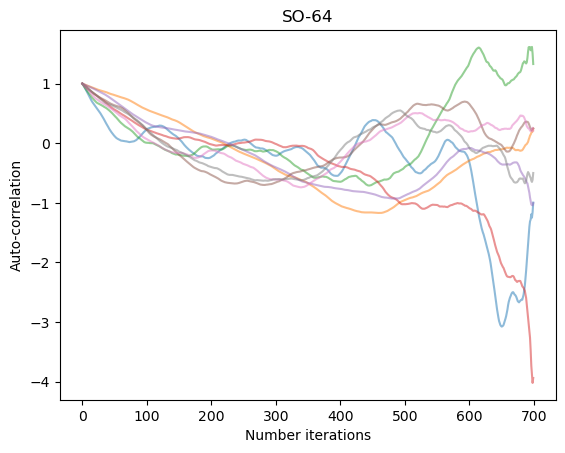

In [ ]:

plt.plot(np.arange(number_steps_sampler), autocorrelation[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-correlation')
plt.show()

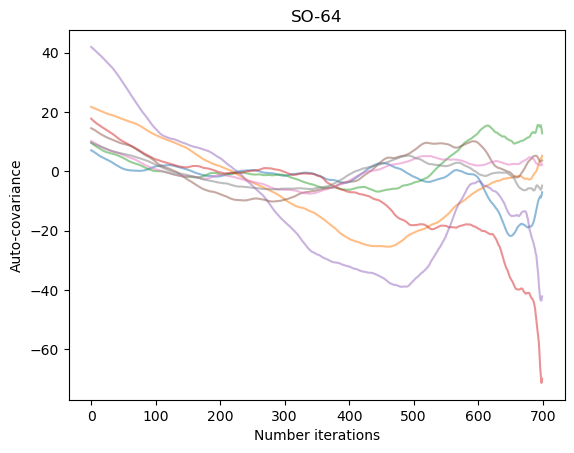

In [ ]:

plt.plot(np.arange(number_steps_sampler), autocovariance[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-covariance')
plt.show()

In [ ]:
autocorrelation_times = np.array([1 + 2*(autocorrelation[i*100:(i+1)*100]/autocorrelation[i*100]).sum(axis=0) for i in range(7)])

In [ ]:
autocorrelation_times

array([[[   63.79095859,   161.09999382,    92.57021867,   118.28840687,
           140.00609   ,   127.25284414,   106.32375782,   124.70962088]],

       [[   36.13165418,   117.98385449, -3269.36898061,    88.14224889,
           128.78817579,  -166.22666612,  -386.79518031,  -109.06069047]],

       [[   57.40231003,  -417.4126455 ,   200.64159748,   -49.771898  ,
          -237.7484772 ,   245.3334249 ,   576.9414696 ,   277.548081  ]],

       [[  252.02666278,   327.10426618,   687.17852401,  2473.33222267,
           311.9451764 ,   135.31273953,   197.66334663,   169.83234917]],

       [[  -22.84121669,   213.27659937,   183.99638445,   331.68981548,
           224.29592965,  -114.16293229,   -55.83473957,  -462.63759895]],

       [[  192.70499288,   140.01772333,  -195.44609265,   204.70822879,
           111.9853972 ,   258.79124916,   194.04872554,    98.90293358]],

       [[ 1272.21949916,    78.94380689,   192.86804936,   358.05416182,
           835.13471414,    55.03

In [ ]:
import emcee.autocorr

In [ ]:
# https://github.com/dfm/emcee/blob/59b6a34323022bc547c3a9fb2173cbffe806af9b/src/emcee/backends/backend.py#L130
emcee.autocorr.integrated_time(samples, tol=0)

array([59.53177363, 85.31270358, 57.24913837, 91.02485449, 81.28128676,
       48.91212108, 53.95907357, 52.25562043])

In [ ]:
mixing_matrix_sampled = last_sample

In [ ]:
cp_cp_noise = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

residual_post_sampling = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

In [ ]:
hp.mollview(residual_post_sampling[0][0])
hp.mollview(residual_post_sampling[0][1])

## Sample study

In [ ]:
ell_arange = np.arange(c_ells_input.shape[1])

In [ ]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-2
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)